In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import requests
import json
import math
from datetime import datetime
import plotly.express as px
import plotly
from urllib.request import urlopen
import matplotlib.pyplot as plt

!pip install sweetviz
import sweetviz as sv

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.1/15.1 MB 67.7 MB/s eta 0:00:00


# FEMA DISASTER DECLARATIONS SUMMARY

Notebook is available online through Google Colab, a web native .ipynb software that does not require downloading or local installation of python. [Access the original here](https://colab.research.google.com/drive/1KZA7Jzho1c8TQj-TwyQfnLQQhs3yG6vv?usp=sharing).



## Introduction and Task Summary


#### Dataset Source/Citation
Federal Emergency Management Agency (FEMA), OpenFEMA Dataset: Disaster Declarations Summaries - v2. Retrieved from https://www.fema.gov/openfema-data-page/disaster-declarations-summaries-v2 on December X, 2023, XX:XX PM EST. This product uses the FEMA OpenFEMA API, but is not endorsed by FEMA. The Federal Government or FEMA cannot vouch for the data or analyses derived from these data after the data have been retrieved from the Agency's website(s).


#### Data Definitions

| Name                     | Title                      | Type      | Description  |
|--------------------------|----------------------------|-----------|--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| femaDeclarationString    | FEMA Declaration String    | text      | Agency standard method for uniquely identifying Stafford Act declarations - <br> Concatenation of declaration type, disaster number and state code. Ex: DR-4393-NC |
| disasterNumber           | Disaster Number            | smallint  | Sequentially assigned number used to designate an event or incident declared as a disaster. <br> For more information on the disaster process, please visit https://www.fema.gov/disasters/how-declared |
| state                    | State                      | text      | The name or phrase describing the U.S. state, district, or territory  |
| declarationType          | Declaration Type           | text      | Two character code that defines if this is a major disaster, fire management, or emergency declaration. <br> For more information on the disaster process, please visit https://www.fema.gov/disasters/how-declared   |
| declarationDate          | Declaration Date           | date      | Date the disaster was declared   |
| fyDeclared               | FY Declared                | smallint  | Fiscal year in which the disaster was declared   |
| incidentType             | Incident Type              | text      | Type of incident such as fire or flood. For more information on incident types, please visit https://www.fema.gov/disasters/how-declared.  |
| declarationTitle         | Declaration Title          | text      | Title for the disaster  |
| ihProgramDeclared        | IH Program Declared        | boolean   | Denotes whether the Individuals and Households program was declared for this disaster. <br> For more information on the program, please visit https://www.fema.gov/assistance/individual/program. <br> To determine which FEMA events have been authorized to receive Individual Assistance, use both ihProgramDeclared and iaProgramDeclared. <br> For more information see https://www.fema.gov/about/openfema/faq                                                                    |
| iaProgramDeclared        | IA Program Declared        | boolean   | Denotes whether the Individual Assistance program was declared for this disaster. <br> For more information on the program, please visit https://www.fema.gov/assistance/individual/program. <br> To determine which FEMA events have been authorized to receive Individual Assistance, use both ihProgramDeclared and iaProgramDeclared. <br> For more information see https://www.fema.gov/about/openfema/faq  |
| paProgramDeclared        | PA Program Declared        | boolean   | Denotes whether the Public Assistance program was declared for this disaster. <br> For more information on the program, please visit https://www.fema.gov/assistance/public/program-overview   |
| hmProgramDeclared        | HM Program Declared        | boolean   | Denotes whether the Hazard Mitigation program was declared for this disaster. <br> For more information on the program, please visit https://www.fema.gov/grants/mitigation/hazard-mitigation   |
| incidentBeginDate        | Incident Begin Date        | date      | Date the incident itself began   |
| incidentEndDate          | Incident End Date          | date      | Date the incident itself ended            |
| disasterCloseoutDate     | Disaster Closeout Date     | date      | Date all financial transactions for all programs are completed    |
| tribalRequest            | Tribal Request             | boolean   | Denotes that a declaration request was submitted directly to the President, independently of a state, by a Tribal Nation.    |
| fipsStateCode            | FIPS State Code            | text      | FIPS two-digit numeric code used to identify the United States, the District of Columbia, US territories, outlying areas of the US and freely associated states   |
| fipsCountyCode           | FIPS County Code           | text      | FIPS three-digit numeric code used to identify counties and county equivalents in the United States, the District of Columbia, US territories, outlying areas of the US and freely associated states. <br> Please note that Indian Reservations are not counties and thus will not have a FIPS county code, please utilize the placeCode field instead. <br> If the designation is made for the entire state, this value will be 000 as multiple (all) counties cannot be entered. |
| placeCode                | Place Code                 | text      | A unique code system FEMA uses internally to recognize locations that takes the numbers '99' + the 3-digit county FIPS code. <br> There are some declared locations that dont have recognized FIPS county codes in which case we assigned a unique identifier     |
| designatedArea           | Designated Area            | text      | The name or phrase describing the geographic area that was included in the declaration  |
| declarationRequestNumber | Declaration Request Number | text      | Number assigned to the declaration request |
| lastIAFilingDate         | Last IA Filing Date        | date      | Last date when IA requests can be filed. <br> Data available after 1998 only. The date only applies if IA has been approved for the disaster.   |
| lastRefresh              | Last Refresh               | datetimez | Date the record was last updated in the API data store  |
| hash                     | Hash                       | text      | MD5 Hash of the fields and values of the record  |
| id                       | ID                         | uuid      | Unique ID assigned to the record |    




####Dataset Discription
Disaster Declarations Summaries is a summarized dataset describing all federally declared disasters. This dataset lists all official FEMA Disaster Declarations, beginning with the first disaster declaration in 1953 and features all three disaster declaration types: major disaster, emergency, and fire management assistance. The dataset includes declared recovery programs and geographic areas (county not available before 1964; Fire Management records are considered partial due to historical nature of the dataset).

Please note the unique structure of the disaster sequencing (due to a numbering system that originated in the 1950's-1970's):

0001-1999 Major Disaster Declaration

2000-2999 Fire Management

3000-3999 Emergency Declaration (Special Emergency)

4000-4999 Major Disaster Declaration

5000-5999 Fire Management

For more information on the disaster declaration process, see https://www.fema.gov/disasters and https://www.fema.gov/disasters/how-declared

This is raw, unedited data from FEMA's National Emergency Management Information System (NEMIS) and as such is subject to a small percentage of human error. The dataset is primarily composed of historical data that was manually entered into NEMIS after it launched in 1998.

Additionally, NEMIS utilizes census data from the United States Census Bureau in which Tribal Nations are listed as localities within a State. As such, disaster declarations for Tribal Nations are currently included in State data.


### Task
1. Data Exploration – Load and explore the OpenFEMA Disaster Declarations Summaries data set, identifying key variables, data types, and potential data quality issues.
1. Data Cleaning – Clean the data for Major Disaster Declarations as needed, addressing any missing values, duplicates, or other data anomalies.
1. Data Visualization – Create visualizations to depict trends or patterns in the data, specifically:
  1. Number of disaster declarations per year
  1. Top ten states with the most disaster declarations
  1. Most frequent types of disasters, nationwide and for all 50 states
  1. Most frequent declaration month for disasters, nationwide and for all 50 states
  1. Disasters “open” the longest (i.e., for disasters with a disaster closeout date in the data set, which ones took the longest to close from the incident start date. Disaster closeout date is the date at which financial transactions for all FEMA assistance programs are completed)
  1. Any other interesting visuals that you think tell the story of this data set
1. Statistical Analysis – Calculate summary statistics and/or identify correlations that help further tell the story of insights you are seeing from your data exploration.
1. Predictive Modeling – Which types of predictive modeling techniques are suitable to apply to this data set? Which are not? What additional data sets may be helpful in building a model that aligns to the goals in FEMA’s Strategic Plan? Be prepared to discuss and explain your thinking during the interview. Bonus points for implementing a predictive model as part of the pre-work assignment.
  * Other data sets you might consider include OpenFEMA, Census, Global Change Research Program, data.gov, Bureau of Labor Statistics, Climate and Economic Justice Screening Tool, CDC/ATSDR Social Vulnerability Index (SVI). FEMA National Risk Index.

## Data Pull

In [2]:
### API REQUEST ###
top=5000
skip=0
baseUrl = 'https://www.fema.gov/api/open/v2/DisasterDeclarationsSummaries?'
res = requests.get(baseUrl+'$count=true&$top=1')
response = res.json()
recCount = response['metadata']['count']
loopNum = math.ceil(recCount / top)

print("START " + str(datetime.now()) + ", " + str(recCount) + " records, " + str(top) + " returned per call, " + str(loopNum) + " iterations needed.")

df = pd.DataFrame.from_dict(response['DisasterDeclarationsSummaries'])[0:0]
i = 0
while (i < loopNum):
  print(baseUrl + "$skip=" + str(skip) + "&$top=" + str(top))
  webUrl = requests.get(baseUrl + "$skip=" + str(skip) + "&$top=" + str(top)).json()
  df=pd.concat([df,pd.DataFrame.from_dict(webUrl['DisasterDeclarationsSummaries'])])
  i+=1
  skip = i * top
  print("Iteration " + str(i) + " done")

print("END " + str(datetime.now()) + ", " + str(len(df)) + " records in file")


START 2023-12-07 14:14:56.298875, 64967 records, 5000 returned per call, 13 iterations needed.
https://www.fema.gov/api/open/v2/DisasterDeclarationsSummaries?$skip=0&$top=5000
Iteration 1 done
https://www.fema.gov/api/open/v2/DisasterDeclarationsSummaries?$skip=5000&$top=5000
Iteration 2 done
https://www.fema.gov/api/open/v2/DisasterDeclarationsSummaries?$skip=10000&$top=5000
Iteration 3 done
https://www.fema.gov/api/open/v2/DisasterDeclarationsSummaries?$skip=15000&$top=5000
Iteration 4 done
https://www.fema.gov/api/open/v2/DisasterDeclarationsSummaries?$skip=20000&$top=5000
Iteration 5 done
https://www.fema.gov/api/open/v2/DisasterDeclarationsSummaries?$skip=25000&$top=5000
Iteration 6 done
https://www.fema.gov/api/open/v2/DisasterDeclarationsSummaries?$skip=30000&$top=5000
Iteration 7 done
https://www.fema.gov/api/open/v2/DisasterDeclarationsSummaries?$skip=35000&$top=5000
Iteration 8 done
https://www.fema.gov/api/open/v2/DisasterDeclarationsSummaries?$skip=40000&$top=5000
Iteration

## Exploratory Data Analysis (EDA)

Basic stats for non-numerical variables:

| variable                 | count | missing | unique values | top value                                | freq of top value |
|--------------------------|-------|---------|---------------|------------------------------------------|-------------------|
| femaDeclarationString    | 64967 | 0       | 4831          | DR-4522-ME                               | 443               |
| state                    | 64967 | 0       | 59            | TX                                       | 5196              |
| declarationType          | 64967 | 0       | 3             | DR                                       | 43952             |
| declarationDate          | 64967 | 0       | 3393          | 2020-03-13T00:00:00.000Z                 | 3692              |
| incidentType             | 64967 | 0       | 25            | Severe Storm                             | 17872             |
| declarationTitle         | 64967 | 0       | 2311          | COVID-19   PANDEMIC                      | 4165              |
| incidentBeginDate        | 64967 | 0       | 3106          | 2020-01-20T00:00:00.000Z                 | 7872              |
| incidentEndDate          | 64474 | 493     | 3160          | 2023-05-11T00:00:00.000Z                 | 7857              |
| disasterCloseoutDate     | 49004 | 15963   | 1857          | 2020-04-21T00:00:00.000Z                 | 741               |
| fipsStateCode            | 64967 | 0       | 59            | 48                                       | 5196              |
| fipsCountyCode           | 64967 | 0       | 347           | 000                                      | 1498              |
| placeCode                | 64967 | 0       | 1304          | 99005                                    | 1010              |
| designatedArea           | 64967 | 0       | 2954          | Washington   (County)                    | 544               |
| declarationRequestNumber | 64967 | 0       | 4831          | 20130                                    | 443               |
| lastIAFilingDate         | 17997 | 46970   | 502           | 2025-09-30T00:00:00.000Z                 | 4156              |
| lastRefresh              | 64967 | 0       | 140           | 2023-05-22T03:41:22.800Z                 | 53661             |
| hash                     | 64967 | 0       | 64967         | 1111d4d4a33f8a6e4d383ac5bd0e60b9bf142da0 | 1                 |
| id                       | 64967 | 0       | 64967         | 9b9a9d9c-8b03-4049-9b16-a3c0d581556c     | 1                 |

This shows that most variables have a value for every row, with exceptions for `incidentEndDate`, `disasterCloseoutDate`, and `lastIAFilingDate`. The most common `fipsCountyCode` is '000', which is a stand in for 'statewide' except when accompanied by a more specific `placeCode`.

Key variables include:
* `state`
* `incidentType`
* `declarationNumber` or `femaDeclarationString` (as a unique identifier)
* `incidentBeginDate` or `declarationDate` (depending on the analysis in question)
* `incidentEndDate` or `disasterCloseoutDate` (depending on the analysis in question)
* `fipsStateCode`, `fipsCountyCode`, and/or `placeCode`

There is a semi-complicated relationship between `placeCode` and the two `fips` variables. When doing analysis by fine-grained location, `placeCode` may be preferred given it is FEMA's created variable and accounts for locations that may not otherwise be covered by `fipsCountyCode`. However, without GIS data that aligns with the shape geographies of these locations, they can be difficult to map onto other GIS based data (such as data for population from U.S. Census Bureau or business data from the Bureau of Labor Statistics). For merging with external data or for graphing with built in GIS shapefiles, it would be important to drop all rows where `placeCode` does not start with a `0` or `99` (thus removing all uniquely named locations where `fipsCountyCode` is `000` which would otherwise mean 'statewide').

I also confirmed that using `declarationNumber` was as effective as using `femaDeclarationString` as a unique identifier for each disaster.

#### Descriptive Statistics

In [ ]:
df.describe().T

count         mean          std     min     25%     50%  \
disasterNumber  64967.0  2603.620823  1415.390107     1.0  1329.0  3099.0   
fyDeclared      64967.0  2004.592270    14.843236  1953.0  1997.0  2007.0   

                   75%     max  
disasterNumber  3562.0  5486.0  
fyDeclared      2018.0  2024.0

In [ ]:
df.describe(include='object').T

count unique  \
femaDeclarationString     64967   4831   
state                     64967     59   
declarationType           64967      3   
declarationDate           64967   3393   
incidentType              64967     25   
declarationTitle          64967   2311   
incidentBeginDate         64967   3106   
incidentEndDate           64474   3160   
disasterCloseoutDate      49004   1857   
fipsStateCode             64967     59   
fipsCountyCode            64967    347   
placeCode                 64967   1304   
designatedArea            64967   2954   
declarationRequestNumber  64967   4831   
lastIAFilingDate          17997    502   
lastRefresh               64967    140   
hash                      64967  64967   
id                        64967  64967   

                                                               top   freq  
femaDeclarationString                                   DR-4522-ME    443  
state                                                           TX   5196  
declarationType                                                 DR  43952  
declarationDate                           2020-03-13T00:00:00.000Z   3692  
incidentType                                          Severe Storm  17872  
declarationTitle                                 COVID-19 PANDEMIC   4165  
incidentBeginDate                         2020-01-20T00:00:00.000Z   7872  
incidentEndDate                           2023-05-11T00:00:00.000Z   7857  
disasterCloseoutDate                      2020-04-21T00:00:00.000Z    741  
fipsStateCode                                                   48   5196  
fipsCountyCode                                                 000   1498  
placeCode                                                    99005   1010  
designatedArea                                 Washington (County)    544  
declarationRequestNumber                                     20130    443  
lastIAFilingDate                          2025-09-30T00:00:00.000Z   4156  
lastRefresh                               2023-05-22T03:41:22.800Z  53661  
hash                      1111d4d4a33f8a6e4d383ac5bd0e60b9bf142da0      1  
id                            9b9a9d9c-8b03-4049-9b16-a3c0d581556c      1

In [117]:
"""for x in df:
  print(df[x].value_counts())
  print("")"""
  #commented out for html version

'for x in df:\n  print(df[x].value_counts())\n  print("")'

#### Reviewing relationship of fips codes and place codes

In [ ]:
df[['fipsStateCode','fipsCountyCode', 'placeCode']].drop_duplicates()

fipsStateCode fipsCountyCode placeCode
0               44            009     99009
1               20            201     99201
2               08            009     99009
3               08            061     99061
4               53            011     99011
...            ...            ...       ...
3387            53            000     61040
3892            38            005     19445
260             36            000     64727
268             20            000     57458
2965            02            240     18600

[4296 rows x 3 columns]

In [ ]:
df.groupby(['fipsStateCode'])['fipsCountyCode', 'placeCode'].aggregate({'fipsCountyCode':'unique','placeCode':'unique'})

<ipython-input-8-40ffa1816a9a>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df.groupby(['fipsStateCode'])['fipsCountyCode', 'placeCode'].aggregate({'fipsCountyCode':'unique','placeCode':'unique'})


fipsCountyCode  \
fipsStateCode                                                      
01             [017, 033, 037, 051, 077, 087, 093, 103, 111, ...   
02             [068, 290, 170, 090, 122, 016, 050, 180, 270, ...   
04             [000, 007, 013, 019, 005, 025, 021, 003, 015, ...   
05             [011, 013, 025, 039, 041, 043, 053, 069, 079, ...   
06             [083, 089, 029, 017, 105, 061, 035, 063, 093, ...   
08             [009, 061, 099, 119, 013, 049, 069, 037, 023, ...   
09                 [005, 007, 000, 009, 011, 001, 003, 013, 015]   
10                                          [003, 001, 005, 000]   
11                                                    [001, 000]   
12             [005, 013, 021, 131, 105, 071, 011, 000, 001, ...   
13             [033, 209, 279, 283, 019, 027, 049, 065, 299, ...   
15                                [001, 003, 007, 009, 000, 005]   
16             [000, 069, 033, 019, 049, 061, 017, 055, 013, ...   
17             [021, 023, 029, 035, 039, 041, 045, 067, 109, ...   
18             [003, 053, 067, 089, 007, 025, 051, 111, 123, ...   
19             [007, 009, 021, 025, 029, 035, 051, 063, 067, ...   
20             [201, 033, 163, 057, 053, 105, 167, 025, 113, ...   
21             [025, 013, 033, 043, 051, 063, 071, 095, 099, ...   
22             [001, 003, 009, 011, 013, 015, 017, 019, 021, ...   
23             [007, 013, 017, 025, 027, 031, 005, 009, 011, ...   
24             [009, 019, 037, 005, 027, 021, 043, 001, 003, ...   
25             [001, 005, 021, 023, 025, 009, 017, 027, 019, ...   
26             [067, 099, 125, 161, 163, 011, 051, 069, 111, ...   
27             [001, 011, 021, 023, 035, 041, 051, 061, 065, ...   
28             [151, 015, 053, 095, 097, 107, 125, 001, 003, ...   
29             [139, 183, 189, 510, 017, 069, 093, 123, 155, ...   
30             [000, 003, 009, 031, 017, 075, 087, 065, 111, ...   
31             [045, 161, 165, 003, 011, 021, 027, 039, 041, ...   
32             [031, 005, 019, 007, 003, 011, 017, 021, 029, ...   
33             [005, 001, 003, 007, 009, 019, 015, 017, 013, ...   
34             [001, 005, 007, 009, 011, 025, 029, 033, 037, ...   
35             [047, 007, 027, 061, 035, 001, 057, 028, 043, ...   
36             [037, 089, 103, 029, 063, 003, 011, 023, 049, ...   
37             [021, 089, 161, 009, 011, 075, 099, 115, 121, ...   
38             [021, 043, 057, 063, 073, 081, 103, 001, 003, ...   
39             [029, 011, 037, 073, 099, 109, 119, 127, 129, ...   
40             [007, 125, 027, 117, 037, 105, 147, 083, 119, ...   
41             [005, 065, 035, 037, 017, 067, 071, 033, 057, ...   
42             [043, 057, 061, 079, 107, 095, 009, 017, 029, ...   
44                                [009, 000, 001, 003, 005, 007]   
45             [045, 077, 001, 003, 005, 007, 009, 011, 013, ...   
46             [103, 047, 033, 113, 007, 011, 025, 037, 039, ...   
47             [007, 065, 153, 005, 013, 017, 021, 027, 033, ...   
48             [221, 425, 035, 133, 065, 485, 053, 049, 243, ...   
49             [035, 043, 037, 017, 049, 053, 027, 011, 039, ...   
50             [001, 003, 009, 011, 013, 005, 007, 015, 017, ...   
51             [027, 185, 003, 007, 011, 029, 033, 037, 047, ...   
53             [011, 059, 033, 061, 001, 077, 007, 065, 047, ...   
54             [019, 047, 005, 043, 045, 011, 039, 059, 099, ...   
55             [001, 017, 019, 023, 053, 057, 063, 081, 103, ...   
56             [001, 007, 041, 013, 025, 029, 043, 039, 031, ...   
60                                [000, 010, 020, 030, 040, 050]   
64                                     [002, 040, 060, 005, 000]   
66                                                    [010, 000]   
68             [000, 010, 030, 040, 070, 080, 090, 110, 120, ...   
69                                     [010, 085, 100, 110, 120]   
70                                                         [000]   
72             [001, 003, 005, 007, 00

In [ ]:
theoryTest = df.groupby(['disasterNumber'])['femaDeclarationString'].unique().reset_index()
theoryTest['len'] = theoryTest['femaDeclarationString'].str.len()
theoryTest

disasterNumber femaDeclarationString  len
0                  1             [DR-1-GA]    1
1                  2             [DR-2-TX]    1
2                  3             [DR-3-LA]    1
3                  4             [DR-4-MI]    1
4                  5             [DR-5-MT]    1
...              ...                   ...  ...
4826            5482          [FM-5482-LA]    1
4827            5483          [FM-5483-OR]    1
4828            5484          [FM-5484-LA]    1
4829            5485          [FM-5485-LA]    1
4830            5486          [FM-5486-LA]    1

[4831 rows x 3 columns]

#### Whole dataset EDA w/ Graphs

                                             |          | [  0%]   00:00 -> (? left)

Report Data EDA.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.



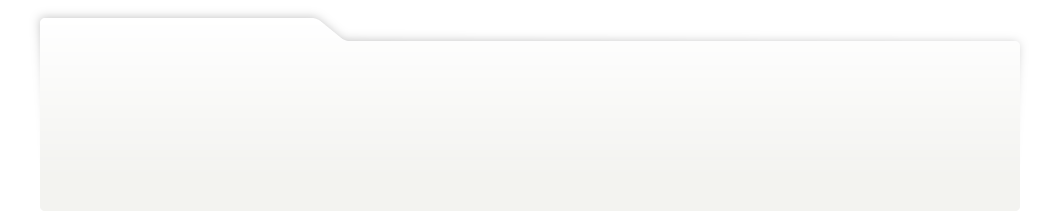
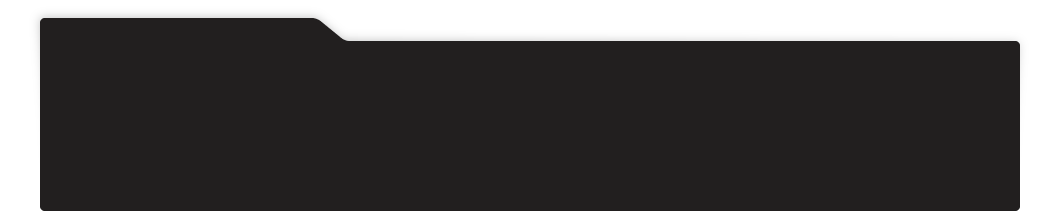
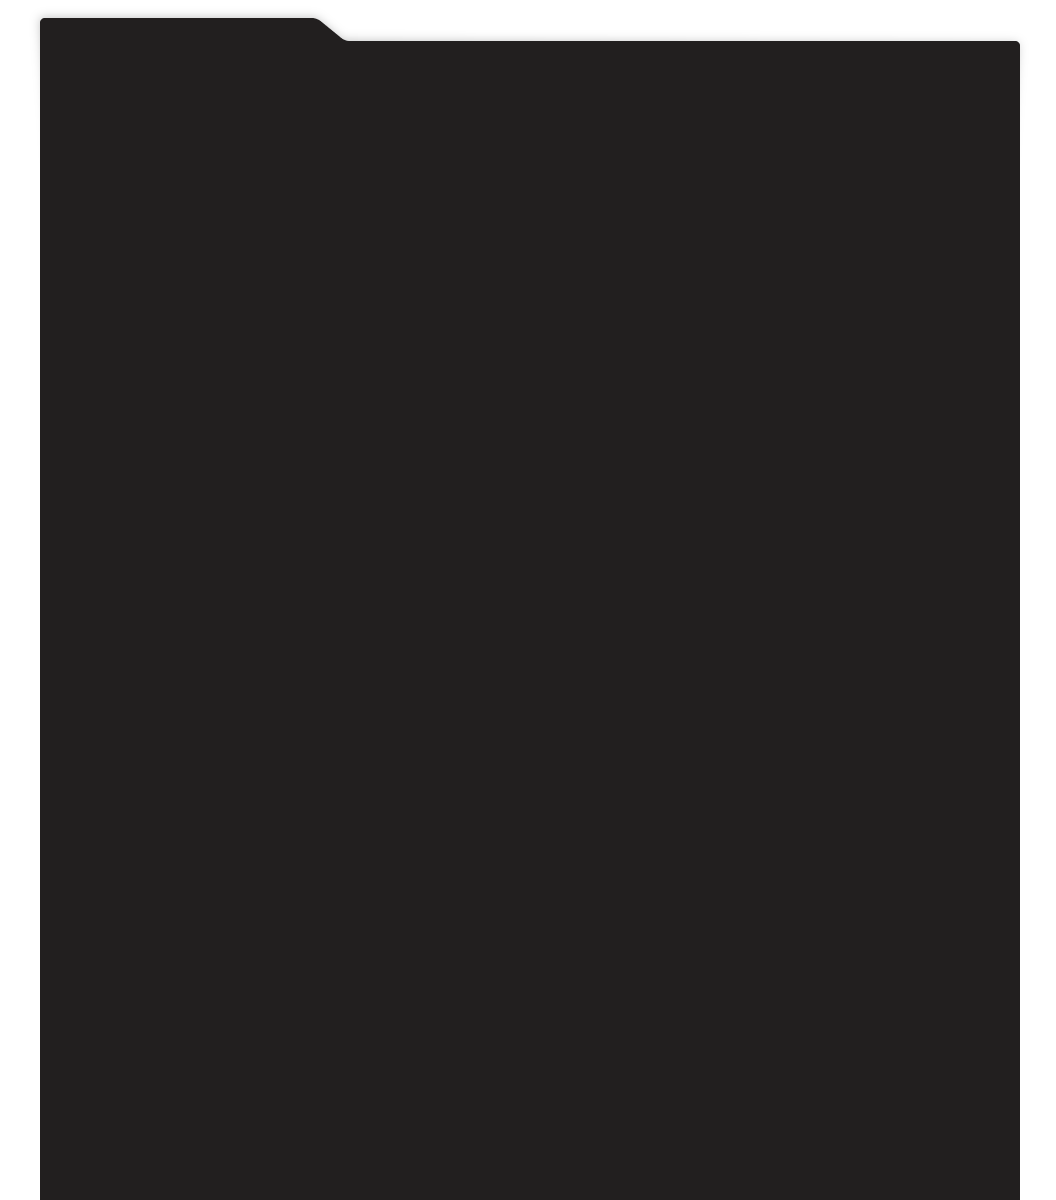
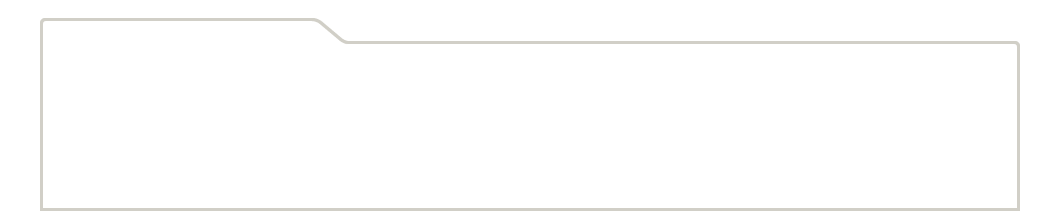
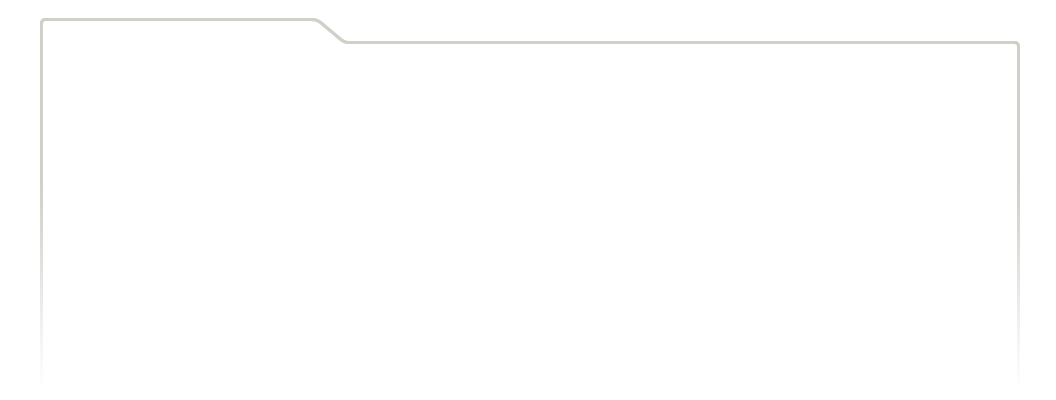
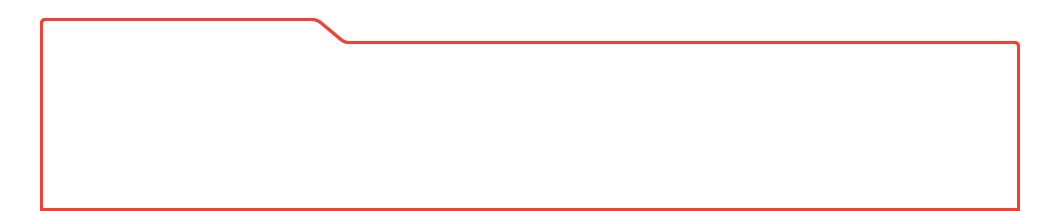
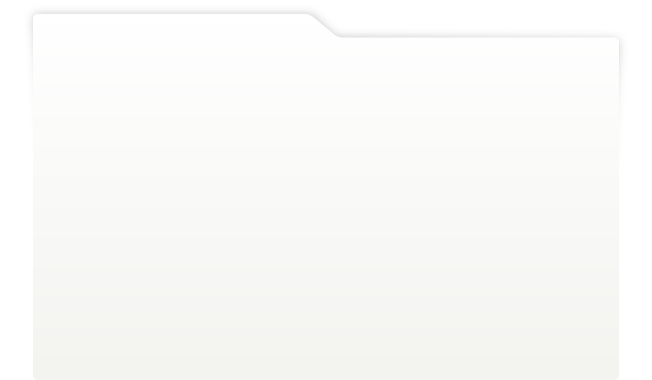
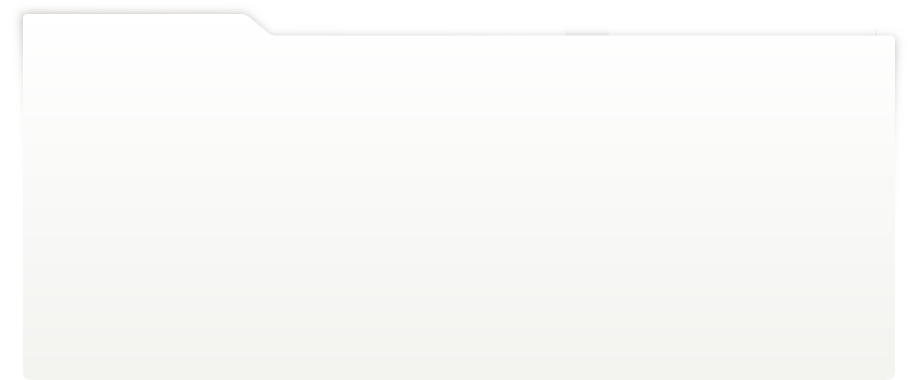
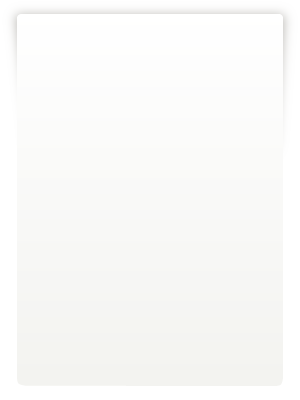
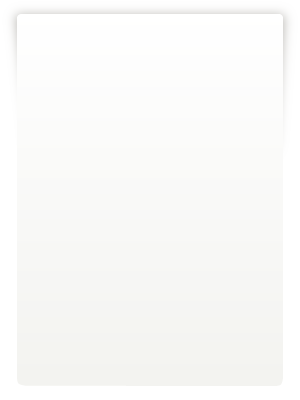
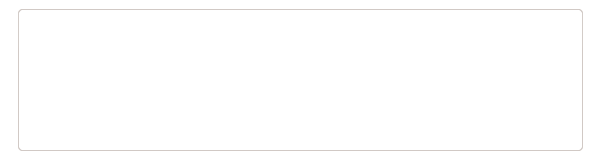
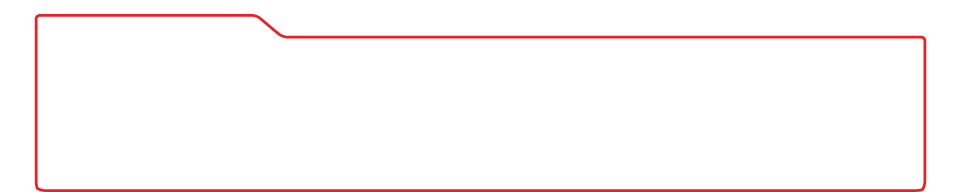
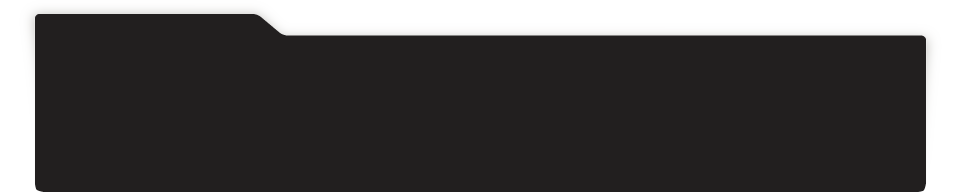
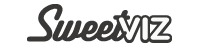
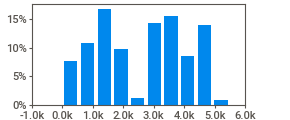
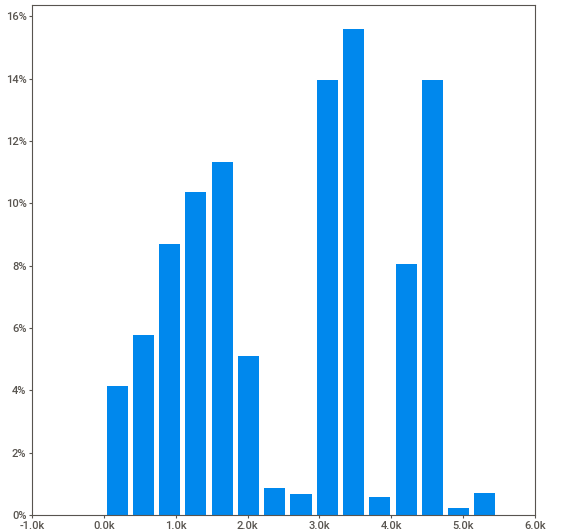
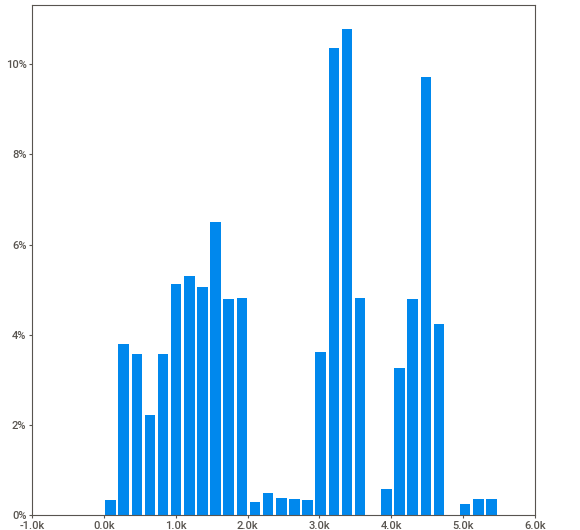
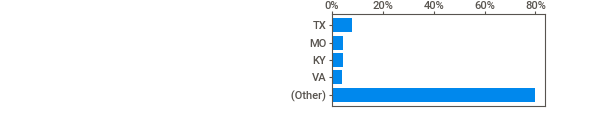
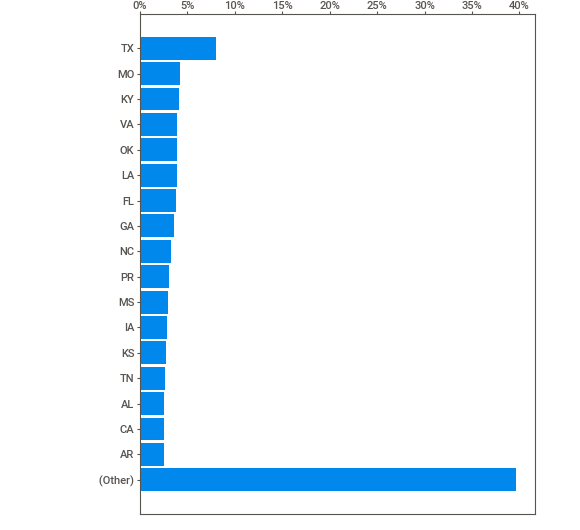
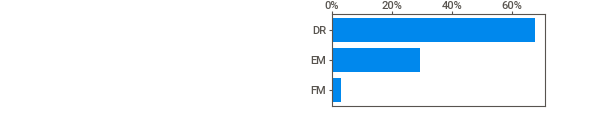
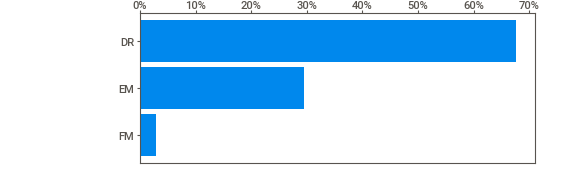
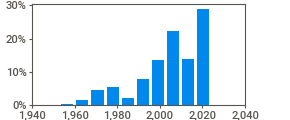
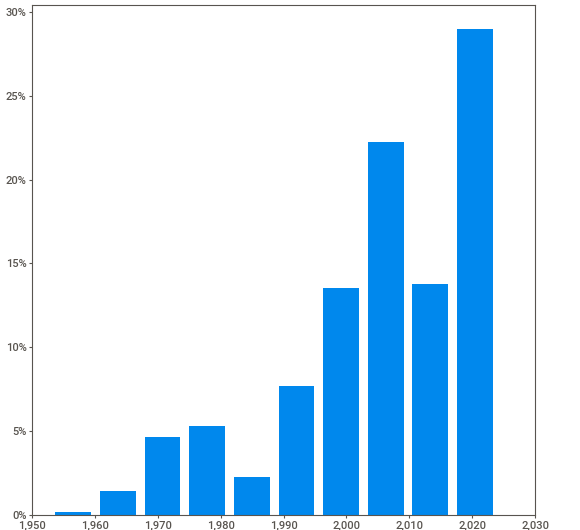
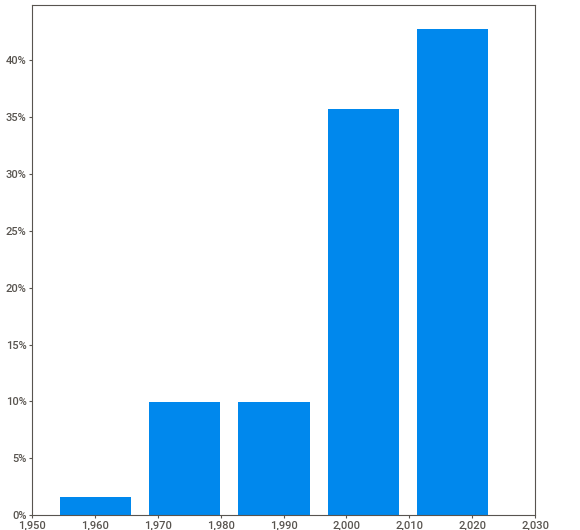
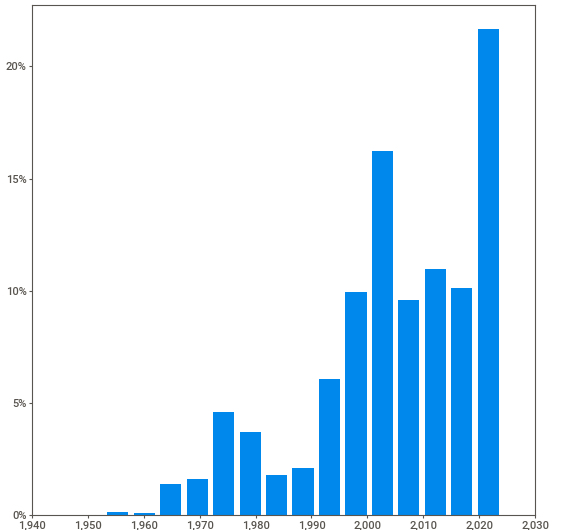
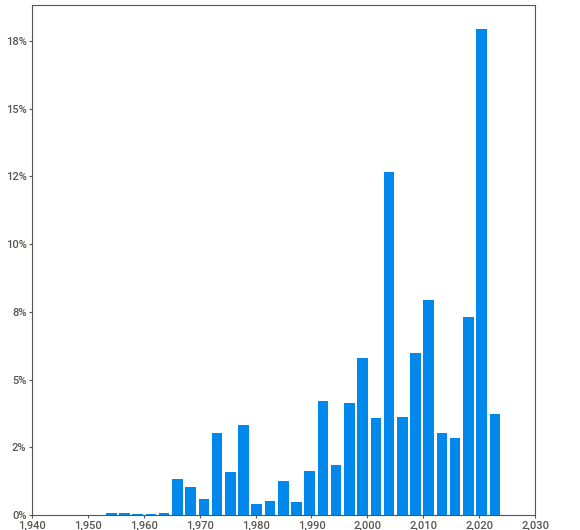
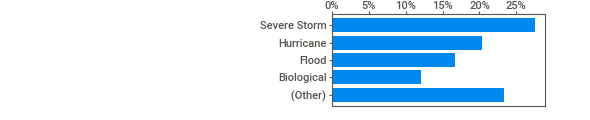
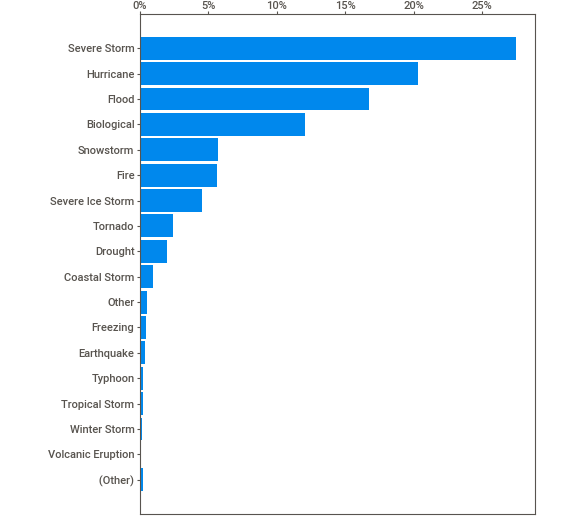
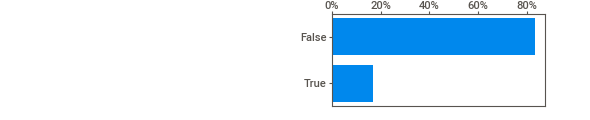
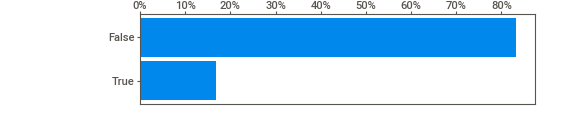
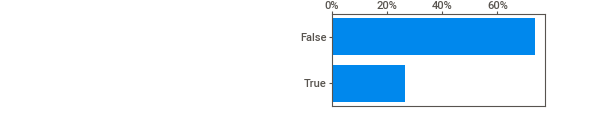
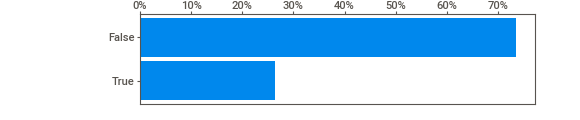
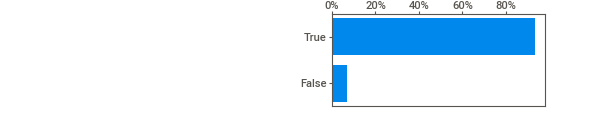
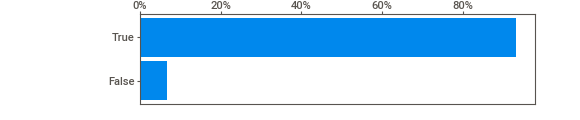
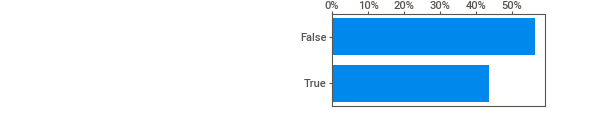
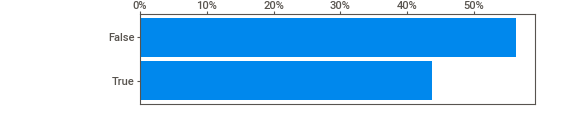
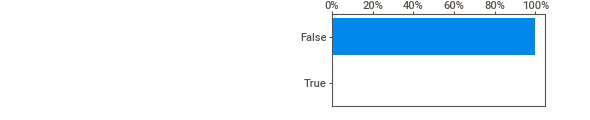
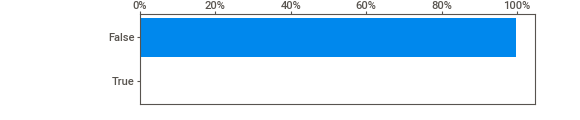
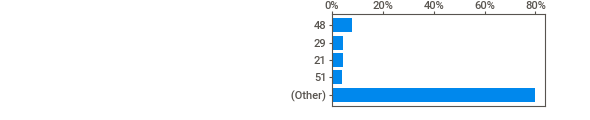
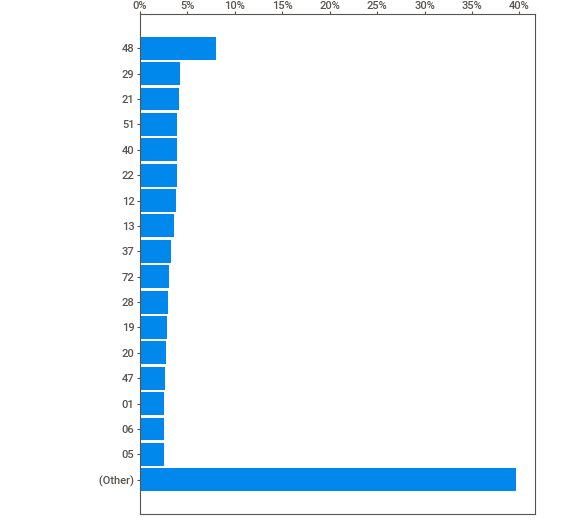
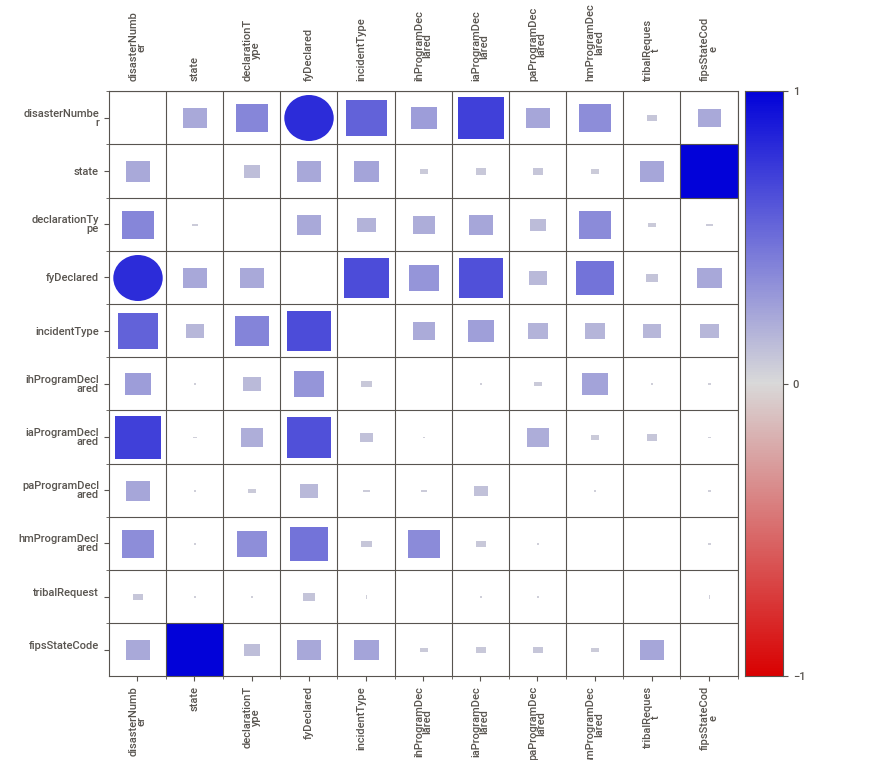
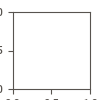

In [ ]:
analyze_report = sv.analyze(df, pairwise_analysis="on")
analyze_report.show_html('Data EDA.html', open_browser=True)
analyze_report.show_notebook(w=None,
                h=None,
                scale=0.8,
                layout='vertical',
                filepath=None)

In [ ]:
sns.pairplot(df)

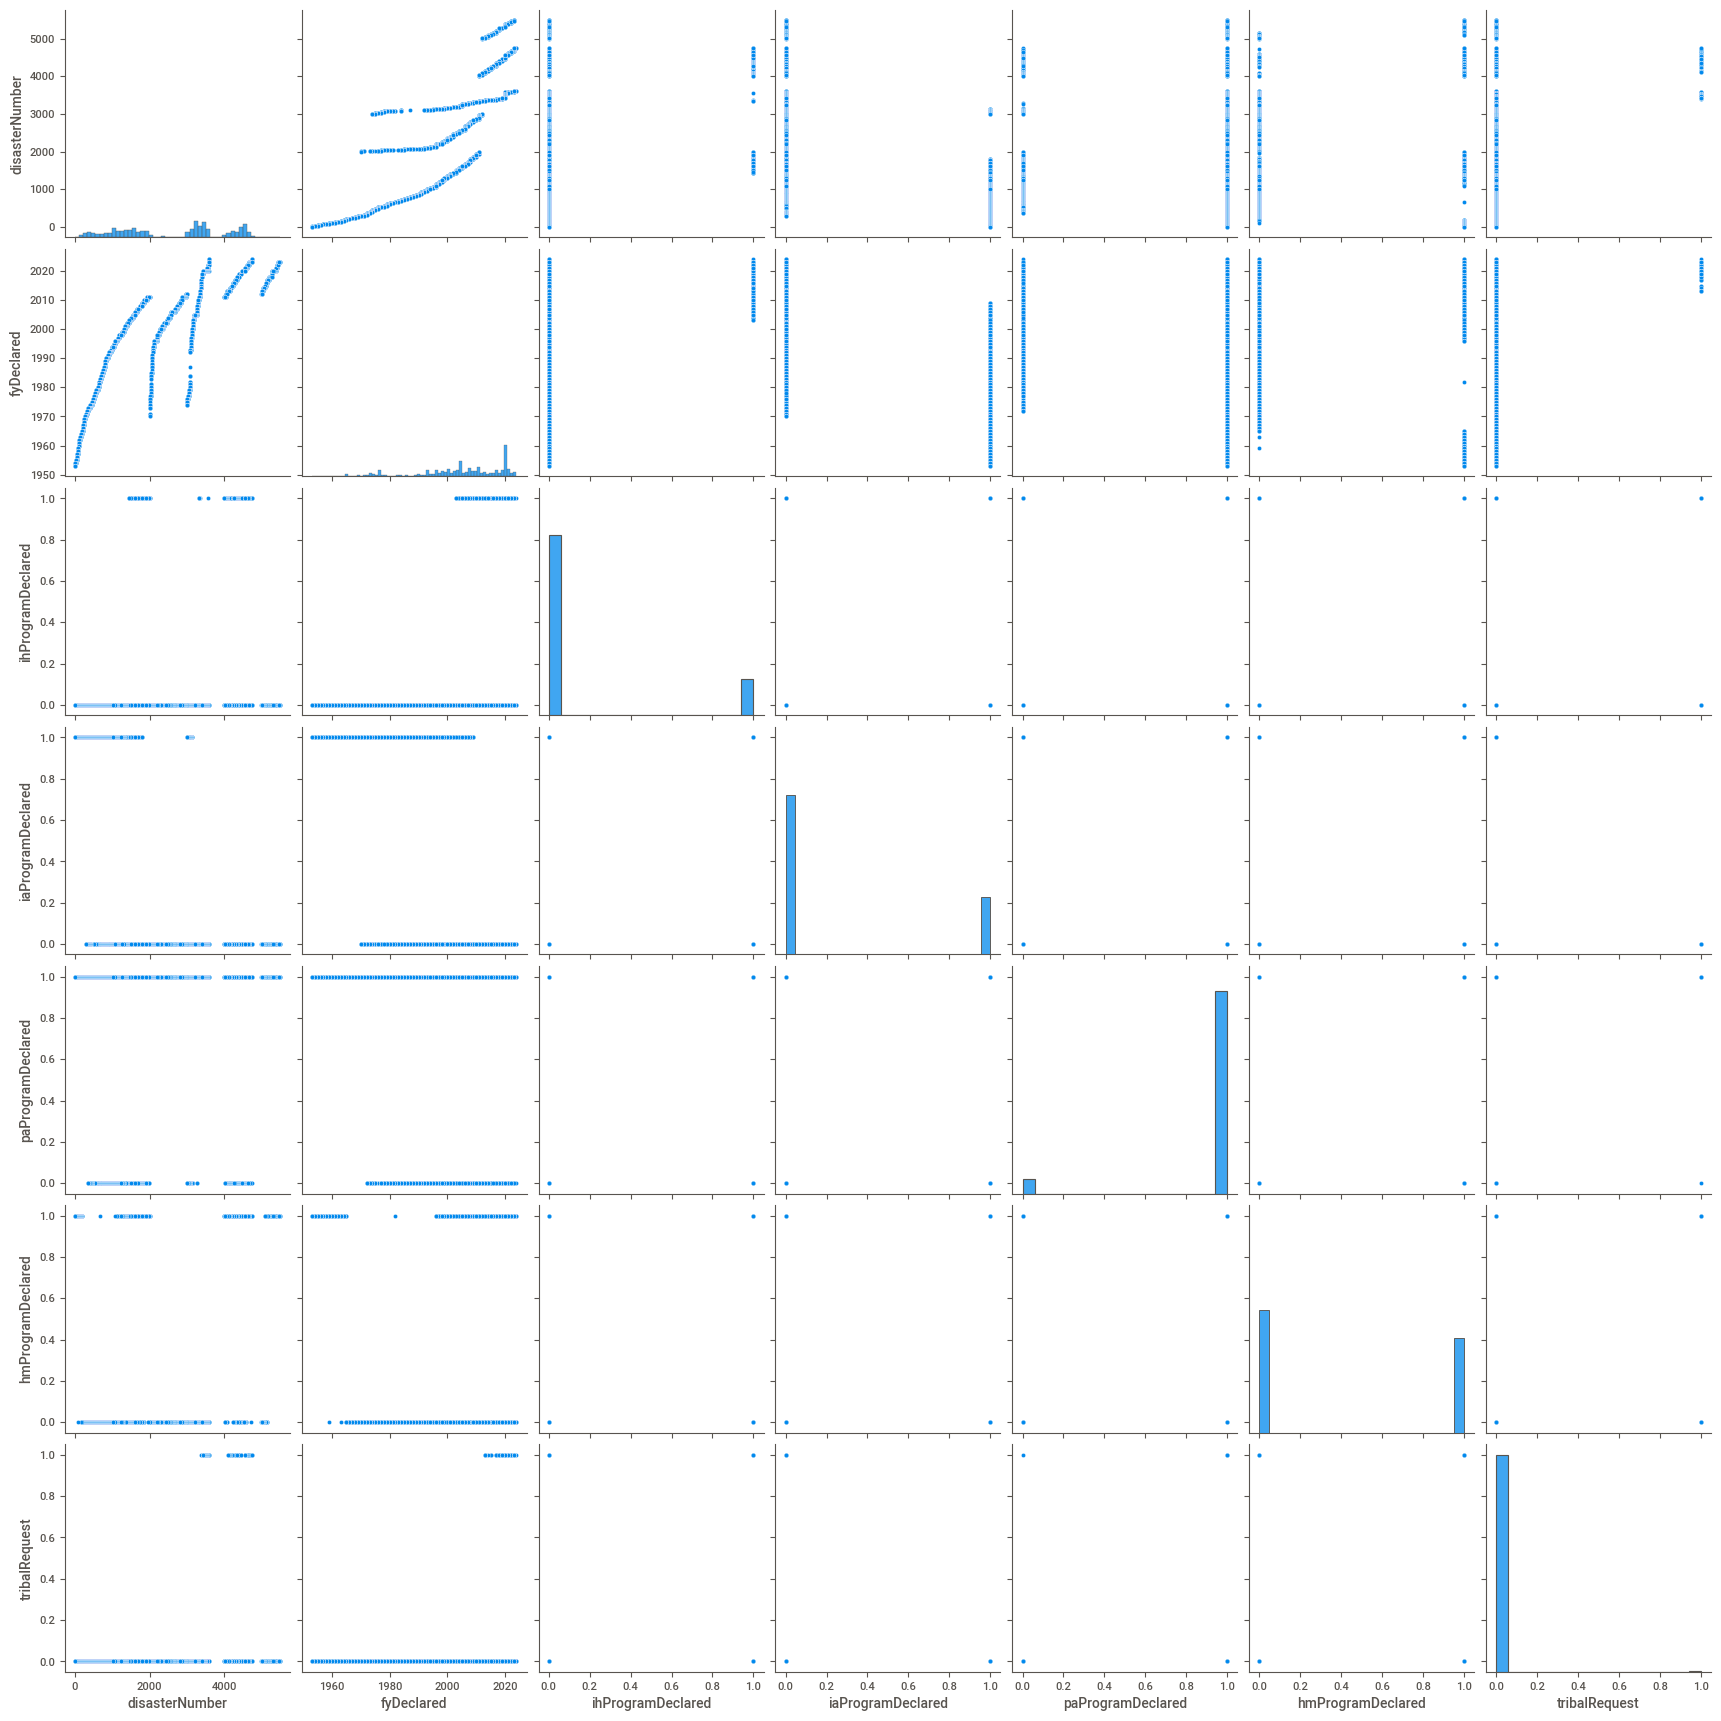



## Data Cleaning

#### Exploration of Data for Data Cleaning

One of the first issues explored surrounded the use of a trailing space on text entry variables. For example, "COVID-19" vs "COVID-19 ". This was discovered by examining the `incidentTitle` variable, grouped by `incidentType`. This is simple to fix, and typically called 'trimming'. Trimming removes excess spaces between words including leading and trailing spaces. Given the very specific nature of `declarationTitle` (e.g., names for every fire, etc.) if it was to be used for more detailed analyses it would likely require additional cleaning. A simple example is 'COVID-19' vs 'COVID-19 PANDEMIC'. In general, this would be a case where I, as the data scientist, would request further information about the origins and usage of some of the data from a subject matter expert. Is there a fundamental difference between the two categories under Tsunami,  'TSUNAMI WAVES' compared to 'TSUNAMI WAVE SURGE', or can those be collapsed together?

Another easy clean to this particular dataset would be standardizing & vs and, unless there is a specific reason. This can be easily fixed, subbing in & for and.

As mentioned in the data brief, there is a lack of detail in the earlier data. Additionally, there is a extreme outlier beginning in 2020 - COVID-19 - which is the only nationwide (or near nationwide) emergency. This occurance will impact some of the later statistics/visualizations - where the visualization with the year or the biological disaster type removed will be shown in addition to the visualization with the COVID-19 data.

Because of the fact that some disasters are listed as 'statewide' is it not appropriate to simply count the raw number of rows associated with each state, instead it would be more appropriate to count the number of `disasterNumber` per `state`.

In [ ]:
df['incidentType'].value_counts()

Severe Storm         17872
Hurricane            13209
Flood                10877
Biological            7857
Snowstorm             3707
Fire                  3648
Severe Ice Storm      2942
Tornado               1572
Drought               1292
Coastal Storm          637
Other                  313
Freezing               301
Earthquake             228
Typhoon                130
Tropical Storm         119
Winter Storm            80
Volcanic Eruption       51
Fishing Losses          42
Mud/Landslide           38
Dam/Levee Break         13
Tsunami                  9
Toxic Substances         9
Chemical                 9
Human Cause              7
Terrorist                5
Name: incidentType, dtype: int64

In [ ]:
df['declarationTitle'].value_counts()

COVID-19 PANDEMIC               4165
SEVERE STORMS AND FLOODING      3852
SEVERE STORMS & FLOODING        3387
COVID-19                        3274
HURRICANE KATRINA EVACUATION    2602
                                ... 
LOCKHART FIRE                      1
HUNTINGTON BROOK FIRE              1
STECKER FIRE                       1
KIEFER FIRE                        1
NV-RED ROCK FIRE 7-11-03           1
Name: declarationTitle, Length: 2311, dtype: int64

In [ ]:
print(df[['incidentType','declarationTitle']].value_counts())

incidentType  declarationTitle            
Biological    COVID-19 PANDEMIC               4165
Flood         SEVERE STORMS & FLOODING        3357
Biological    COVID-19                        3274
Severe Storm  SEVERE STORMS AND FLOODING      2854
Hurricane     HURRICANE KATRINA EVACUATION    2315
                                              ... 
Fire          ROCKFARM FIRE                      1
              ROCK FIRE                          1
              ROBERTSON DRAW FIRE                1
              ROBBERS FIRE                       1
              VELMA FIRE COMPLEX                 1
Length: 2399, dtype: int64


In [ ]:
df.groupby('incidentType')['declarationTitle'].unique().reset_index()

incidentType                                   declarationTitle
0          Biological           [COVID-19 PANDEMIC, COVID-19, COVID-19 ]
1            Chemical                                   [CHEMICAL SPILL]
2       Coastal Storm  [SEVERE STORM AND FLOODING, SEVERE STORM, TROP...
3     Dam/Levee Break  [SEVERE STORMS AND FLOODING, POTENTIAL FAILURE...
4             Drought  [DROUGHT, EXTREME FIRE HAZARD, WATER SHORTAGE,...
5          Earthquake  [EARTHQUAKE, EARTHQUAKE AND AFTERSHOCKS, EARTH...
6                Fire  [QUEENS RIVER FIRE, HADDAM FIRE, NAKIA CREEK F...
7      Fishing Losses  [RED TIDE-TOXIC ALGAE, THE EL NINO (THE SALMON...
8               Flood  [SEVERE STORMS, FLOODING, AND TORNADOES, SEVER...
9            Freezing  [SEVERE FREEZE, SEVERE WINTER COLD AND FROST, ...
10        Human Cause  [EXPLOSION AT FEDERAL COURTHOUSE IN OKLAHOMA C...
11          Hurricane  [HURRICANE IDALIA, TROPICAL STORM OLIVIA, HURR...
12      Mud/Landslide  [LANDSLIDE, SEVERE STORM, FLOODING, LANDSLIDES...
13              Other  [STRAIGHT-LINE WINDS, ELEVATED LEVELS OF LEAD ...
14   Severe Ice Storm  [SEVERE WINTER STORMS, SEVERE WINTER STORMS, L...
15       Severe Storm  [SEVERE STORMS AND FLOODING, SEVERE WINTER STO...
16          Snowstorm  [SEVERE WINTER STORM AND SNOWSTORM, SEVERE WIN...
17          Terrorist                 [EXPLOSIONS, FIRES AND EXPLOSIONS]
18            Tornado  [SEVERE STORMS, STRAIGHT-LINE WINDS, AND TORNA...
19   Toxic Substances  [CONTAMINATED WATER, WATER CONTAMINATION, METH...
20     Tropical Storm  [TROPICAL STORM HILARY, TROPICAL STORM BOLAVEN...
21            Tsunami                [TSUNAMI WAVES, TSUNAMI WAVE SURGE]
22            Typhoon  [TYPHOON WUTIP, SUPER TYPHOON YUTU, TYPHOON MA...
23  Volcanic Eruption  [KILAUEA VOLCANIC ERUPTION AND EARTHQUAKES, PU...
24       Winter Storm  [SEVERE WINTER STORM, SEVERE WINTER STORMS AND...

In [ ]:
df['declarationTitleTrim']=df['declarationTitle'].str.strip()

In [ ]:
df.groupby('incidentType')['declarationTitleTrim'].unique()

incidentType
Biological                               [COVID-19 PANDEMIC, COVID-19]
Chemical                                              [CHEMICAL SPILL]
Coastal Storm        [SEVERE STORM AND FLOODING, SEVERE STORM, TROP...
Dam/Levee Break      [SEVERE STORMS AND FLOODING, POTENTIAL FAILURE...
Drought              [DROUGHT, EXTREME FIRE HAZARD, WATER SHORTAGE,...
Earthquake           [EARTHQUAKE, EARTHQUAKE AND AFTERSHOCKS, EARTH...
Fire                 [QUEENS RIVER FIRE, HADDAM FIRE, NAKIA CREEK F...
Fishing Losses       [RED TIDE-TOXIC ALGAE, THE EL NINO (THE SALMON...
Flood                [SEVERE STORMS, FLOODING, AND TORNADOES, SEVER...
Freezing             [SEVERE FREEZE, SEVERE WINTER COLD AND FROST, ...
Human Cause          [EXPLOSION AT FEDERAL COURTHOUSE IN OKLAHOMA C...
Hurricane            [HURRICANE IDALIA, TROPICAL STORM OLIVIA, HURR...
Mud/Landslide        [LANDSLIDE, SEVERE STORM, FLOODING, LANDSLIDES...
Other                [STRAIGHT-LINE WINDS, ELEVATED LEVELS OF LE

In [ ]:
df.groupby('incidentType')['declarationTitleTrim'].nunique()

incidentType
Biological              2
Chemical                1
Coastal Storm          21
Dam/Levee Break         5
Drought                 9
Earthquake             11
Fire                 1461
Fishing Losses          3
Flood                 192
Freezing               12
Human Cause             3
Hurricane             155
Mud/Landslide           6
Other                  26
Severe Ice Storm       15
Severe Storm          268
Snowstorm              53
Terrorist               2
Tornado                48
Toxic Substances        6
Tropical Storm          6
Tsunami                 2
Typhoon                50
Volcanic Eruption       5
Winter Storm            4
Name: declarationTitleTrim, dtype: int64

In [ ]:
df['declarationTitleTrim'].value_counts()

COVID-19 PANDEMIC                  4165
SEVERE STORMS AND FLOODING         3892
COVID-19                           3692
SEVERE STORMS & FLOODING           3387
HURRICANE KATRINA EVACUATION       2602
                                   ... 
VENUS FIRE COMPLEX                    1
CASA FIRE                             1
OBEE FIRE                             1
CEMENT FIRE                           1
MT-WEDGE CANYON FIRE-07/18/2003       1
Name: declarationTitleTrim, Length: 2279, dtype: int64

In [ ]:
df['declarationTitleTrim']=df['declarationTitleTrim'].apply(lambda x: x.replace(' AND ',' & '))
df['declarationTitleTrim']=df['declarationTitleTrim'].apply(lambda x: x.replace(' PANDEMIC',''))

In [ ]:
df['declarationTitleTrim'].value_counts()

COVID-19                                 7857
SEVERE STORMS & FLOODING                 7279
HURRICANE KATRINA EVACUATION             2602
SEVERE WINTER STORM                      2423
SEVERE STORMS, TORNADOES, & FLOODING     1889
                                         ... 
VOLUSIA FIRE COMPLEX                        1
LAKE OLYMPIA FIRE                           1
LA BARRANCA FIRE                            1
PARKS HIGHWAY (TAMARACK) FIRE               1
OR-WYETH/HERMAN CREEK FIRE 09-02-2003       1
Name: declarationTitleTrim, Length: 2255, dtype: int64

#### Creation of State+County FIPS dataset for GIS-type visualization
As stated previously, the following code cleans the data to only include rows where `placeCode` starts with the values of 99 or 0. This is a necessary step as the crosswalk with the census data (used to make sure that all states and counties are included - just in case there existed any in the US that did not have a previous disaster declaration.

Another reason for this is that some of the locations are coded with just the state and with a fip of 000, to indicate statewide, but to properly visualize it at a county level the data will need to be expanded (or exploded in python terms) to turn the 'statewide' row into many county specific rows.


In [3]:
#Gather county fips to convert state-wide rows to individual counties for mapping
fipspop = pd.read_csv('https://www2.census.gov/geo/docs/reference/cenpop2020/county/CenPop2020_Mean_CO.txt',converters={'STATEFP': str,'COUNTYFP': str})
scfips=fipspop.groupby('STATEFP')['COUNTYFP'].unique().reset_index()

fipspop['COUNTYFIP']= fipspop['STATEFP'] + fipspop['COUNTYFP']
cofips=fipspop.groupby('COUNTYFIP')['COUNAME'].unique().reset_index().rename(columns = {'COUNTYFIP':'COUNTYFP'})
cofips['COUNAME'] = cofips['COUNAME'].apply(lambda x: x[0])

scfips=scfips.explode('COUNTYFP').reset_index()
scfips['COUNTYFP']= scfips['STATEFP'] + scfips['COUNTYFP']
scfips['STATEFP'] = scfips['STATEFP'] + "000"

df['FIPS'] = df['fipsStateCode'] + df['fipsCountyCode']
dftemp=df.copy()
##drop all rows not starting with 99 or 0 in placecode, dftemp will be used for all exploration of GIS Fips
dftemp = dftemp[dftemp['placeCode'].astype(str).str.startswith(('99','0'))]
dftemp=pd.merge(dftemp,scfips,right_on='STATEFP',left_on='FIPS', how="outer")
dftemp.loc[dftemp['COUNTYFP'].isnull(),'COUNTYFP'] = dftemp['FIPS']
dftemp=pd.merge(dftemp,cofips,on='COUNTYFP', how="left")

In [ ]:
dftemp

femaDeclarationString  disasterNumber state declarationType  \
0                 FM-5464-RI            5464    RI              FM   
1                 DR-4653-RI            4653    RI              DR   
2                 EM-3563-RI            3563    RI              EM   
3                 DR-4212-RI            4212    RI              DR   
4                 DR-4107-RI            4107    RI              DR   
...                      ...             ...   ...             ...   
107757              DR-11-NH              11    NH              DR   
107758              DR-11-NH              11    NH              DR   
107759              DR-11-NH              11    NH              DR   
107760              DR-11-NH              11    NH              DR   
107761              DR-11-NH              11    NH              DR   

                 declarationDate  fyDeclared  incidentType  \
0       2023-04-14T00:00:00.000Z        2023          Fire   
1       2022-05-12T00:00:00.000Z        2022     Snowstorm   
2       2021-08-21T00:00:00.000Z        2021     Hurricane   
3       2015-04-03T00:00:00.000Z        2015  Severe Storm   
4       2013-03-22T00:00:00.000Z        2013  Severe Storm   
...                          ...         ...           ...   
107757  1953-07-02T00:00:00.000Z        1953          Fire   
107758  1953-07-02T00:00:00.000Z        1953          Fire   
107759  1953-07-02T00:00:00.000Z        1953          Fire   
107760  1953-07-02T00:00:00.000Z        1953          Fire   
107761  1953-07-02T00:00:00.000Z        1953          Fire   

                         declarationTitle  ihProgramDeclared  \
0                       QUEENS RIVER FIRE              False   
1       SEVERE WINTER STORM AND SNOWSTORM              False   
2                         HURRICANE HENRI              False   
3       SEVERE WINTER STORM AND SNOWSTORM              False   
4       SEVERE WINTER STORM AND SNOWSTORM              False   
...                                   ...                ...   
107757                        FOREST FIRE              False   
107758                        FOREST FIRE              False   
107759                        FOREST FIRE              False   
107760                        FOREST FIRE              False   
107761                        FOREST FIRE              False   

        iaProgramDeclared  ...  lastIAFilingDate               lastRefresh  \
0                   False  ...              None  2023-05-22T03:41:22.800Z   
1                   False  ...              None  2023-05-22T03:41:22.800Z   
2                   False  ...              None  2023-11-14T12:21:15.130Z   
3                   False  ...              None  2023-05-22T03:41:22.800Z   
4                   False  ...              None  2023-05-22T03:41:22.800Z   
...                   ...  ...               ...                       ...   
107757               True  ...              None  2023-05-22T03:41:22.800Z   
107758               True  ...              None  2023-05-22T03:41:22.800Z   
107759               True  ...              None  2023-05-22T03:41:22.800Z   
107760               True  ...              None  2023-05-22T03:41:22.800Z   
107761               True  ...              None  2023-05-22T03:41:22.800Z   

                                            hash  \
0       1111d4d4a33f8a6e4d383ac5bd0e60b9bf142da0   
1       fc3219452d4738e50fc0a08a676988bd27519b7f   
2       7dd834ffef547aed0d3b9893a8d6bd29ef530778   
3       cf39052db0a4a588f629b8c2a785a715a855f97e   
4       c9e186c7d3f7ec2ca50fbcab43c983b46c279b39   
...                                          ...   
107757  558a6f08af78ab93badaf33976115762a1ebded5   
107758  558a6f08af78ab93badaf33976115762a1ebded5   
107759  558a6f08af78ab93badaf33976115762a1ebded5   
107760  558a6f08af78ab93badaf33976115762a1ebded5   
107761  558a6f08af78ab93badaf33976115762a1ebded5   

                                          id             declarationTitleTrim  \
0       9

#### Creation of dataset to include all years a disaster declaration was in effect for GIS-type visualization

The original dataset included start and end dates for each disaster included in the row; however, to properly show what declarations were active (not just declared) in any given year, a new dataset is needed. This is done by creating a list of years between each start and end for each disaster, and then expanding (or exploding, as it is called in python) the dataset so each of those years has its own row per disaster declaration per location. It was also important to create four new variables for the visualization, to track whether or not it was a new or continuing disaster (`incidentTypeNew`,`incidentTypeContinuing`,`disasterNumberNew`,`disasterNumberContinuing`) this dataset will be used in a later visualzation.

In [4]:
dftemp['declarationYear']=pd.to_datetime(dftemp['declarationDate']).dt.year
dftemp['disasterCloseoutDate'] = pd.to_datetime(dftemp['disasterCloseoutDate'])

today_date = datetime.now().strftime('%Y-%m-%d')
dftemp['disasterCloseoutDate'] = dftemp['disasterCloseoutDate'].fillna(today_date)
dftemp['disasterCloseoutYear'] = pd.to_datetime(dftemp['disasterCloseoutDate']).dt.year

def generate_year_range(row):
    return list(range(row['declarationYear'], row['disasterCloseoutYear'] + 1))

dftemp['yearRange'] = dftemp.apply(generate_year_range, axis=1)

df_exploded = dftemp.explode('yearRange')

df_exploded = df_exploded.rename(columns={'yearRange': 'Year'})
df_exploded['incidentTypeNew'] = df_exploded.apply(lambda row: row['incidentType'] if row['Year'] == row['declarationYear'] else None, axis=1)
df_exploded['incidentTypeContinuing'] = df_exploded.apply(lambda row: row['incidentType'] if row['Year'] != row['declarationYear'] else None, axis=1)
df_exploded['disasterNumberNew'] = df_exploded.apply(lambda row: row['disasterNumber'] if row['Year'] == row['declarationYear'] else None, axis=1)
df_exploded['disasterNumberContinuing'] = df_exploded.apply(lambda row: row['disasterNumber'] if row['Year'] != row['declarationYear'] else None, axis=1)

df_exploded

femaDeclarationString  disasterNumber state declarationType  \
0                 FM-5464-RI            5464    RI              FM   
1                 DR-4653-RI            4653    RI              DR   
1                 DR-4653-RI            4653    RI              DR   
2                 EM-3563-RI            3563    RI              EM   
2                 EM-3563-RI            3563    RI              EM   
...                      ...             ...   ...             ...   
107760              DR-11-NH              11    NH              DR   
107761              DR-11-NH              11    NH              DR   
107761              DR-11-NH              11    NH              DR   
107761              DR-11-NH              11    NH              DR   
107761              DR-11-NH              11    NH              DR   

                 declarationDate  fyDeclared incidentType  \
0       2023-04-14T00:00:00.000Z        2023         Fire   
1       2022-05-12T00:00:00.000Z        2022    Snowstorm   
1       2022-05-12T00:00:00.000Z        2022    Snowstorm   
2       2021-08-21T00:00:00.000Z        2021    Hurricane   
2       2021-08-21T00:00:00.000Z        2021    Hurricane   
...                          ...         ...          ...   
107760  1953-07-02T00:00:00.000Z        1953         Fire   
107761  1953-07-02T00:00:00.000Z        1953         Fire   
107761  1953-07-02T00:00:00.000Z        1953         Fire   
107761  1953-07-02T00:00:00.000Z        1953         Fire   
107761  1953-07-02T00:00:00.000Z        1953         Fire   

                         declarationTitle  ihProgramDeclared  \
0                       QUEENS RIVER FIRE              False   
1       SEVERE WINTER STORM AND SNOWSTORM              False   
1       SEVERE WINTER STORM AND SNOWSTORM              False   
2                         HURRICANE HENRI              False   
2                         HURRICANE HENRI              False   
...                                   ...                ...   
107760                        FOREST FIRE              False   
107761                        FOREST FIRE              False   
107761                        FOREST FIRE              False   
107761                        FOREST FIRE              False   
107761                        FOREST FIRE              False   

        iaProgramDeclared  ...  STATEFP  COUNTYFP     COUNAME declarationYear  \
0                   False  ...      NaN     44009  Washington            2023   
1                   False  ...      NaN     44009  Washington            2022   
1                   False  ...      NaN     44009  Washington            2022   
2                   False  ...      NaN     44009  Washington            2021   
2                   False  ...      NaN     44009  Washington            2021   
...                   ...  ...      ...       ...         ...             ...   
107760               True  ...    33000     33017   Strafford            1953   
107761               True  ...    33000     33019    Sullivan            1953   
107761               True  ...    33000     33019    Sullivan            1953   
107761               True  ...    33000     33019    Sullivan            1953   
107761               True  ...    33000     33019    Sullivan            1953   

       disasterCloseoutYear  Year incidentTypeNew incidentTypeContinuing  \
0                      2023  2023            Fire                   None   
1                      2023  2022       Snowstorm                   None   
1                      2023  2023            None              Snowstorm   
2                      2023  2021       Hurricane                   None   
2                      2023  2022            None              Hurricane   
...                     ...   ...             ...                    ...   
107760                 1956  1956            None                   Fire   
107761                 1956  1953            Fire                   None   
107761 

## Data Visualizations

#### Number of Disaster Declarations per Year

Below, the first two visualization shows the number of disaster declarations per year using all data. This is done by couning the number of unique diaster numbers per year, the first visualization is done using the library Seaboarn and can be suitable for sharing as an image in reports and as an attachment. The second is made using plotly, which enables additional data on hover and dashboard-lite interactivity. Most subsequent visualizations are done in both when the visualization is easily able to be made in either format.

Of note in these graphs is the steady increase in the number of disasters. This is likely three-fold reasons:
1. that disaster reporting/record-keeping is improving over time,
1. that the greater population leads to the U.S. having an overall higher density - when disasters happen, they are more likely to impact more people than in the past, which increases the likelihood of the disaster reaching the level of a FEMA disaster declaration,
1. that the impacts of human habitation have had an impact on climate, causing increasingly unpredictable changes to the weather patterns and other natural phenomenon.

It is also important to draw attention to the spike in 2020 in the rise of disaster declarations. This is due in large part to COVID-19 Pandemic, which lead to the single largest disaster declaration.

In [ ]:
df['declarationYear']=pd.to_datetime(df['declarationDate']).dt.year
df_disaster_year=df.groupby(['declarationYear'])['disasterNumber'].nunique().reset_index().rename(columns={'disasterNumber':'Count of Unique Disasters','declarationYear':'Year'})
sns.lineplot(x="Year", y="Count of Unique Disasters",
             data=df_disaster_year).set(title='Number of Disaster Declarations per Year')

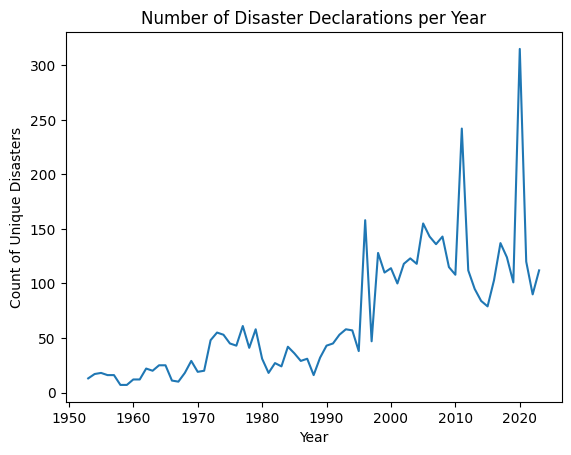

In [ ]:
fig = px.line(df_disaster_year, x="Year", y="Count of Unique Disasters", title="Number of Disaster Declarations per Year")
fig.show()
fig.write_html("numberdisasterdeclarationsyear_line.html")

#### Top Ten States with the Most Disaster Declarations

Based on the number of unique assigned disaster numbers per state, Texas and California have the most at 372 and 371, respectively. These are also among the largest states with a great number of counties (far more in Texas [246] than California [58]). The actual raw number of disaster declarations might not be the best indication of impact. Rather, what is the land or human impact (above and beyond the minimum required to be declared a disaster)? How many of the disaster in these two states affected the entire state vs just a few counties. However, it is important to note that this is not a competition, each of these disaster declarations are made in the face of some suffering.

The next nearest is Oklahoma, with over a hundred less disastered declared (225). The numbers continue to fall at a steady pace from there for subsequent states ranked in the top ten.

Alternative metrics for top ten impacted states could include the spread or impact of the disaster or introducing weighting (local disaster declarations having a lower weight and those widespread having higher weight). However, reporting raw numbers such as this also has its place in tracking the number of disaster declarations issued, regardless of size or impact.

In [ ]:
df_top_10=df.groupby(['state'])['disasterNumber'].nunique().reset_index().rename(columns={'disasterNumber':'Count of Unique Disasters','state':'State'}).sort_values(['Count of Unique Disasters'],ascending=False)[0:10]

fig = sns.catplot(x="State", y="Count of Unique Disasters",kind="bar",palette="dark",alpha=.6,
             data=df_top_10).set(title='Top Ten States with the Most Disaster Declarations')
fig

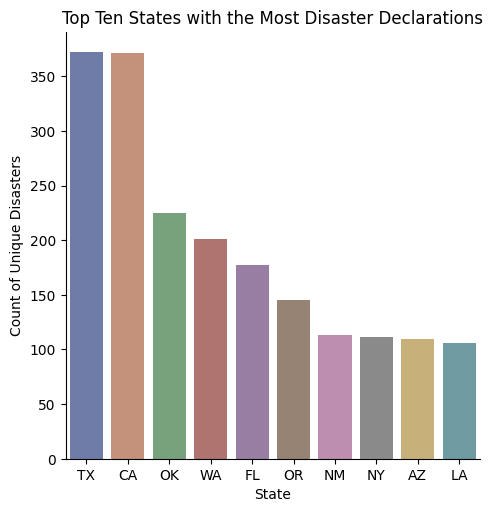


In [ ]:

fig = px.bar(df_top_10, x="State", y="Count of Unique Disasters", title="Top Ten States with the Most Disaster Declarations")
fig.show()
fig.write_html("top10statesmostdisasters_bar.html")

#### Most Frequent Types of Disasters Nationwide

The most frequent types of disasters can be approached from two different angles. The first is a simple report that showcases the number of disasters per disaster category, regardless of year. The second one answers the question, for the years that there were disasters in that category, on average how many were there?

In the first scenario, fire was the most common disaster in the nation. In the second, biological disaster was the common disaster, with more biological disasters being declared in the three years that biological disaster occurred than fires in all the years that fire disasters occured. The preference for one visualization over the other largely depends on the narrative's handling of time - is the data to be averaged across years, or summed regardless of years?

Overall, time will have a great impact of subsequent visualizations.

In [ ]:
df_mf_disastertype=df.groupby(['incidentType'])['disasterNumber'].nunique().reset_index().rename(columns={'disasterNumber':'Count of Unique Disasters','incidentType':'Disaster Type'}).sort_values(['Count of Unique Disasters'],ascending=False)

sns.catplot(x="Disaster Type", y="Count of Unique Disasters",kind="bar",palette="dark",alpha=.6,
             data=df_mf_disastertype).set(title='Most Frequent Types of Disasters Nationwide').set_xticklabels(rotation=90)

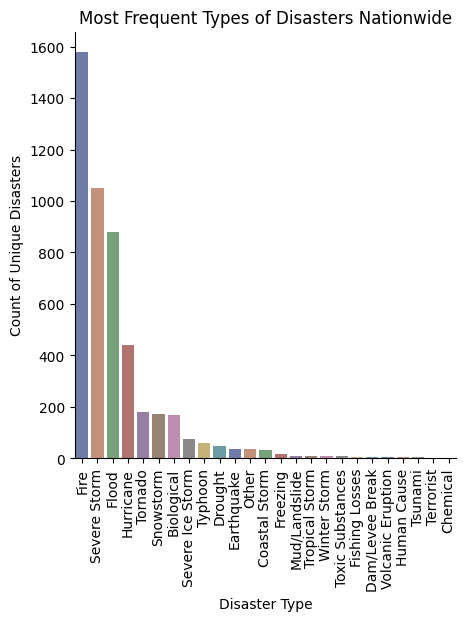

In [ ]:
df_mf_disastertypeyear=df.groupby(['incidentType','declarationYear'])['disasterNumber'].nunique().reset_index().rename(columns={'disasterNumber':'Count of Unique Disasters','incidentType':'Disaster Type'}).sort_values(['Count of Unique Disasters'],ascending=False)

sns.catplot(x="Disaster Type", y="Count of Unique Disasters",kind="bar",palette="dark",alpha=.6,
             data=df_mf_disastertypeyear).set(title='Most Frequent Types of Disasters Nationwide, \n averaged across years').set_xticklabels(rotation=90)

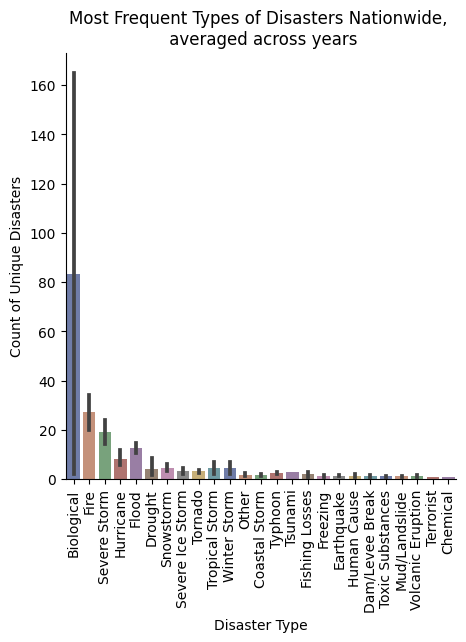

In [ ]:
fig = px.bar(df_mf_disastertype, x="Disaster Type", y="Count of Unique Disasters", title="Most Frequent Types of Disasters Nationwide")
fig.show()
fig.write_html("mostfreqdisastertypes_bar.html")


#### Most frequent types of disasters for all 50 states

There are three different graphs below that showcase different approaches to visualize the most frequent types of disasters for all states. The first is a dot plot or strip plot that shows the top ten types of disasters (from the previous visualizations) and how frequent they are for each of the 50 states + territories and District of Columbia (the y axis). The data is ordered from most state with most overall disasters to the one with fewest disasters. This allows for some comparison of data across the types of disasters, and to see how each of the top 10 major disaster types contributed to the total (far left column is total disasters per state).

In this view, it is clear that the top states make up the majority of the fire disasters, while they also have a lower number of severe storms. While, beginning with Alabama, is is clear that severe storms begin to overtake fire as the most common disaster type and trend downward from there. This also shows that typhoon, which making the top 10 disaster types, only impacts a small number of states and terroritories at the bottom of the graph. Earthquake is also relatively discrete, with most states never having an earthquake disaster. Note that each of the disaster types have their own axis values, otherwise if they had set x-axes the size of the fire category would make it hard to tell detail in the other categories. It does make it harder to compare categories, but not impossible so long as the ranges of each disaster type are understood and respected.

The second graph shows what is the most frequent disaster per state, and how frequent it is in that state. This is relatively straightforward, with the column height showing frequency and column color showing disaster type.

The third graph is a choropleth graph, a type of thematic/statistical map where the color of the shaded area indicates a statistical value. In this case, the colors are the most common type of disaster in that state. The number of disasters of that type is available on hover. Choropleth graphs will form the backbone of the additional graphs.

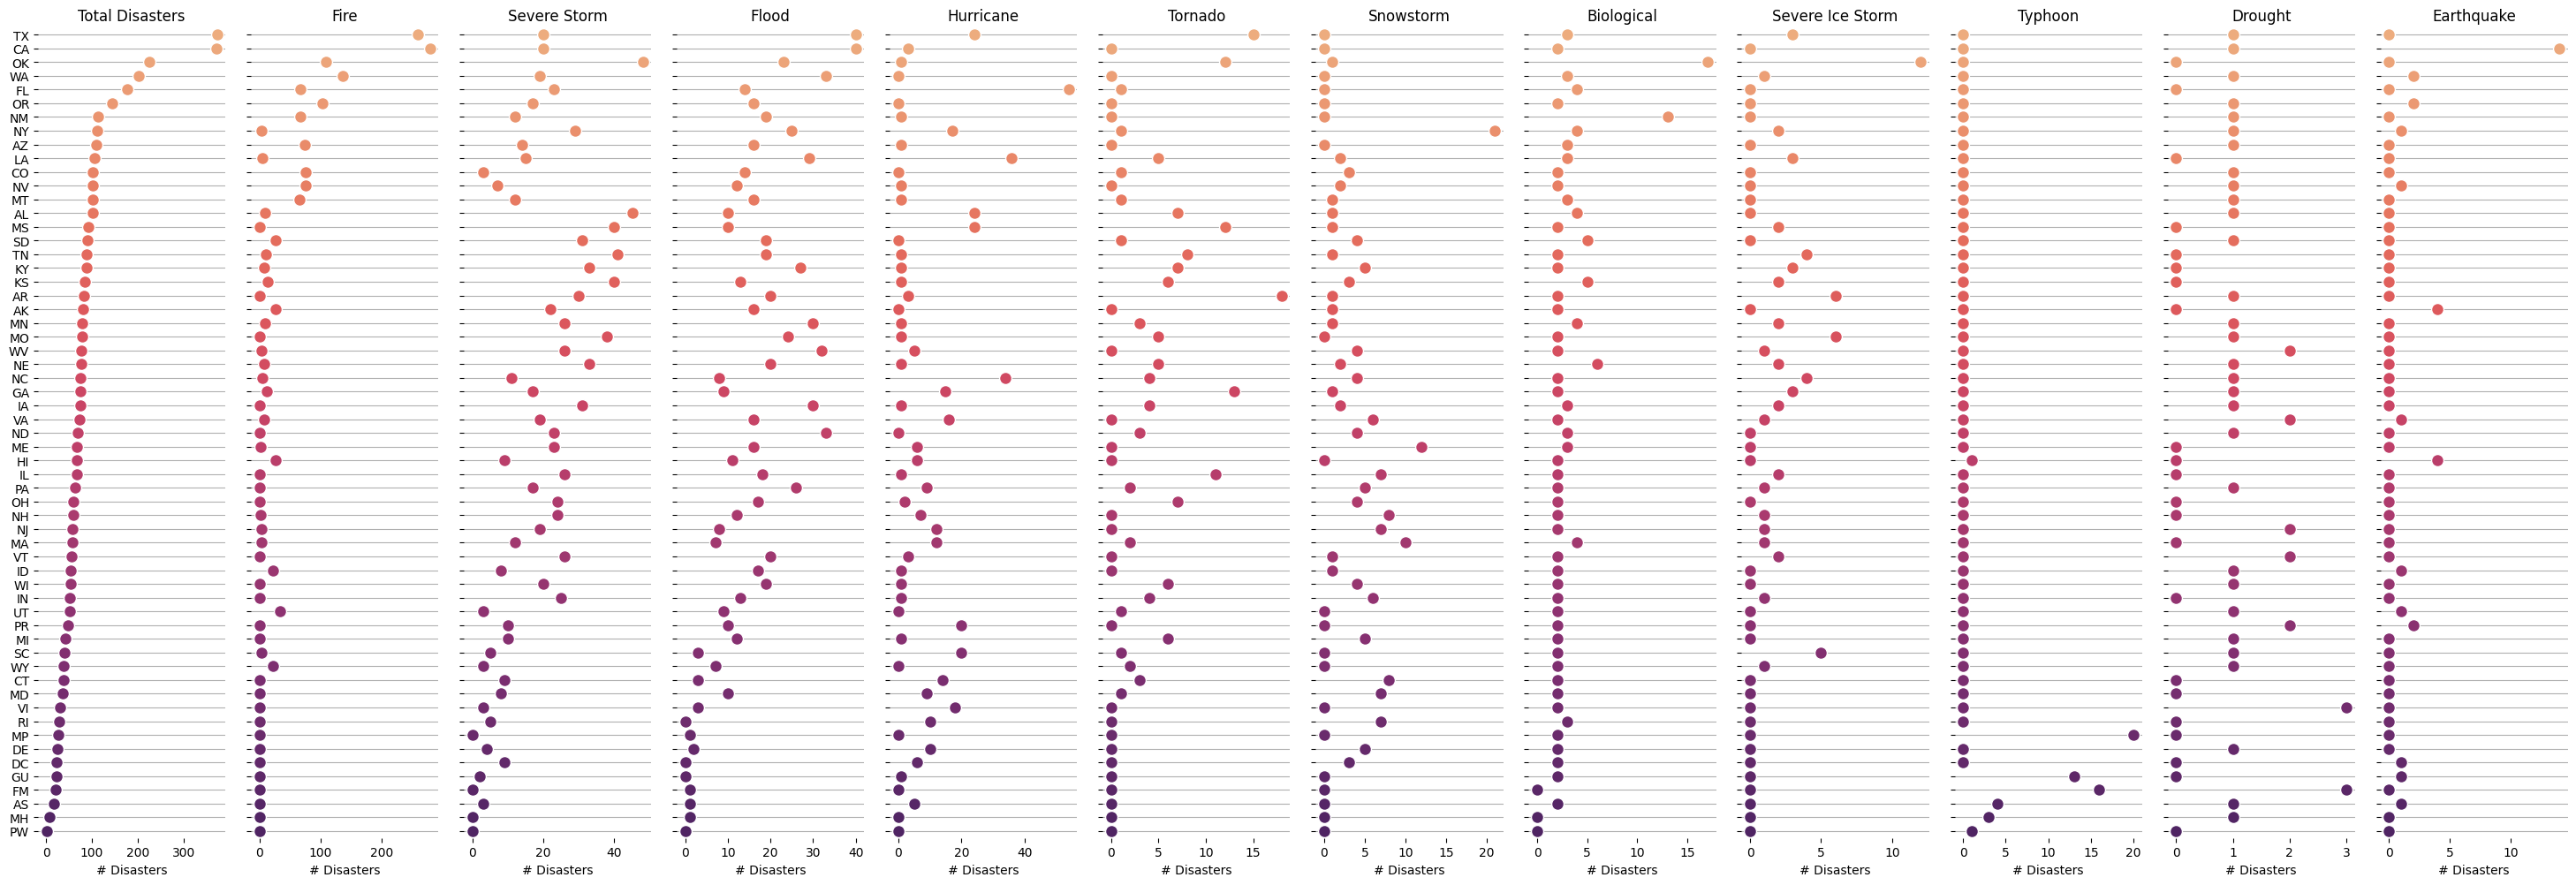

In [5]:
catego=['Total Disasters','Fire','Severe Storm','Flood','Hurricane','Tornado','Snowstorm','Biological','Severe Ice Storm','Typhoon','Drought','Earthquake','State']
df_state_mf_disastertype=df.groupby(['incidentType','state'])['disasterNumber'].nunique().reset_index().rename(columns={'disasterNumber':'Count of Unique Disasters','incidentType':'Disaster Type','state':'State'}).sort_values(['Count of Unique Disasters'],ascending=False)

df_state_mf_disastertype_pvt=df_state_mf_disastertype.pivot(index='State', columns='Disaster Type', values='Count of Unique Disasters').fillna(0)
df_state_mf_disastertype_pvt['Total Disasters']=df_state_mf_disastertype_pvt.sum(axis=1)#.reset_index()
#
df_state_mf_disastertype_pvt=df_state_mf_disastertype_pvt.reset_index()
df_state_mf_disastertype_pvt=df_state_mf_disastertype_pvt[catego]
df_state_mf_disastertype_pvt

# Make the PairGrid
g = sns.PairGrid(df_state_mf_disastertype_pvt.sort_values('Total Disasters', ascending=False),
                 x_vars=['Total Disasters','Fire','Severe Storm','Flood','Hurricane','Tornado','Snowstorm','Biological','Severe Ice Storm','Typhoon','Drought','Earthquake'], y_vars=["State"], hue='State',palette="flare",
                 height=10, aspect=.25)

# Draw a dot plot using the stripplot function
g.map(sns.stripplot, size=10, orient="h", jitter=False,
       palette="flare", linewidth=1, edgecolor="w")

# Use the same x axis limits on all columns and add better labels
g.set(xlabel="# Disasters", ylabel="")

# Use semantically meaningful titles for the columns
titles = ['Total Disasters','Fire','Severe Storm','Flood','Hurricane','Tornado','Snowstorm','Biological','Severe Ice Storm','Typhoon','Drought','Earthquake']

for ax, title in zip(g.axes.flat, titles):

    # Set a different title for each axes
    ax.set(title=title)

    # Make the grid horizontal instead of vertical
    ax.xaxis.grid(False)
    ax.yaxis.grid(True)

sns.despine(left=True, bottom=True)

In [ ]:
disaster_counts = df.groupby(['state', 'incidentType'])['disasterNumber'].nunique().reset_index().rename(columns={'disasterNumber': 'Counts'})

# Function to concatenate incident types with the same highest count
def get_most_frequent_disasters(group):
    max_count = group['Counts'].max()
    most_frequent = group[group['Counts'] == max_count]['incidentType'].tolist()
    return ', '.join(most_frequent)

most_frequent_disasters = disaster_counts.groupby('state').apply(get_most_frequent_disasters).reset_index(name='Most Frequent Disaster Types')
merged_df = most_frequent_disasters.merge(disaster_counts, left_on=['state', 'Most Frequent Disaster Types'], right_on=['state', 'incidentType'])

# Create a bar plot using Plotly Express
fig = px.bar(merged_df, x='state', y='Counts', color='Most Frequent Disaster Types',
             title='Most Frequent Types of Disasters for All 50 States')

# Update layout for better readability
fig.update_layout(
    xaxis={'categoryorder': 'total descending', 'tickangle': -90},
    yaxis_title='Frequency',
    xaxis_title='State',
    barmode='group',
    xaxis_tickfont_size=10
)

# Show the figure
fig.show()
fig.write_html("mostfreqdisastertypestates_bar.html")



In [ ]:

fig = px.choropleth(merged_df,
                    locations='state',  # This column in df_disasters should contain the state abbreviations.
                    color='incidentType',  # This will color the map by the most common disaster.
                    locationmode='USA-states',  # This sets the locations to the USA's state boundaries.
                    scope="usa",  # This scopes the map to show only the USA.
                    color_continuous_scale=px.colors.sequential.Plasma,  # Optional: Picking a color scale.
                    title='Most Frequent Types of Disasters for All 50 States',
                    hover_data=['Counts'])
fig.show()
fig.write_html("mostfreqdisastertypestates_choropleth.html")


#### Most frequent declaration month for disasters, nationwide

Using all data, there are two main spikes for number of disasters by month, the first being in March and the second being in the fall (August/September). The spike in the spring is a clear outlier as shown in the boxplot below, and the third graph shows what it looks like without the outlier of 2020. In that graph, the most common month is August followed by September.

Rather than just looking at months as a discrete unit, I also split the data by day of the year and forced the x-axis to align with months to see if there is greater danger at the start or end of certain months. In this view the spike from the Biological incident type becomes very stark, as so many were declared all at the same time. Without 2020 data, shown in the subsequent graph, the disaster declarations tend to spread out over the year with spikes at the beginning and end of the years. These spikes would need to be examined in greater detail in the future to determine if the dates are correctly input, or look for another explanation.

The final set of clustered bar graphs show what types of disasters happen in which months. The first shows all disaster types, while the second shows only those 'natural disasters' - although the term can be debated - so it excludes Biological, Chemical, Toxic Substances, Human Cause, and Terrorist disaster types. This was done to see if the remaining 'natural' disasters were seasonally bound. The resultant graph shows these types of disasters favor late summer and fall.

In [ ]:
df['declarationMonth']=pd.to_datetime(df['declarationDate']).dt.strftime('%b')
month_names = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]

df_disaster_month=df.groupby(['declarationMonth','declarationYear'])['disasterNumber'].nunique().reset_index().rename(columns={'disasterNumber':'Count of Unique Disasters','declarationMonth':'Month'})
sns.boxplot(x="Month", y="Count of Unique Disasters",
             data=df_disaster_month,order=month_names).set(title='Number of Disaster Declarations per Month, Nationwide')

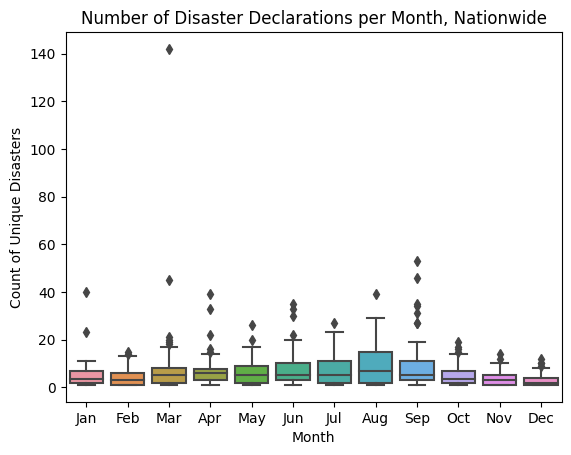

In [ ]:
df['declarationMonth']=pd.to_datetime(df['declarationDate']).dt.month
df_disaster_month_num=df.groupby(['declarationMonth','declarationYear'])['disasterNumber'].nunique().reset_index().rename(columns={'disasterNumber':'Count of Unique Disasters','declarationMonth':'Month'})

sns.lineplot(x="Month", y="Count of Unique Disasters",
             data=df_disaster_month_num).set(title='Number of Disaster Declarations per Year by Month on Average, Nationwide')


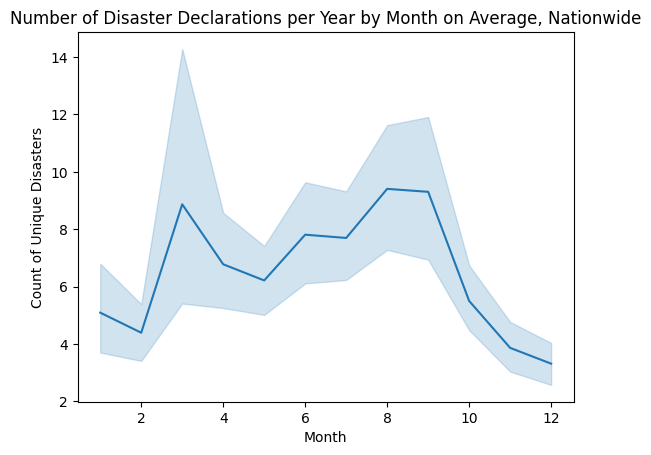

In [ ]:
sns.lineplot(x="Month", y="Count of Unique Disasters",
             data=df_disaster_month_num[df_disaster_month_num['declarationYear']!=2020]).set(title='Number of Disaster Declarations per Year by Month on Average, Nationwide\nExcluding 2020')

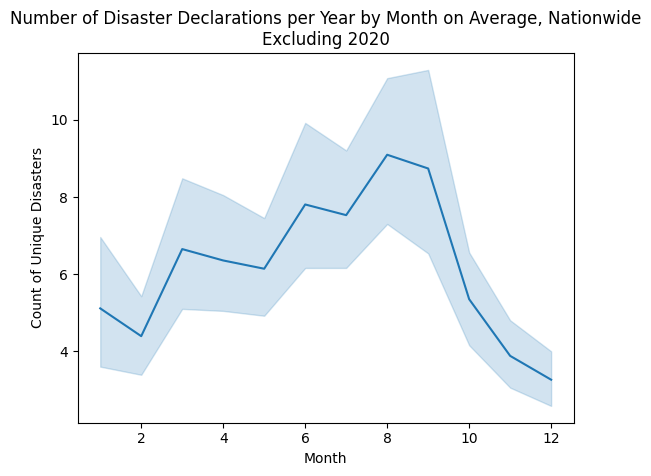

In [ ]:
fig = px.box(df_disaster_month, x="Month", y="Count of Unique Disasters",
             title='Number of Disaster Declarations per Month, Nationwide',
             category_orders={"Month": month_names}, hover_data='declarationYear')

# Show the figure
fig.show()

fig.write_html("numberdisasterdeclaredmonth_box.html")


In [ ]:
df['declarationDOTY']=pd.to_datetime(df['declarationDate']).dt.dayofyear
df_disaster_month_doty=df.groupby(['declarationDOTY','declarationYear'])['disasterNumber'].nunique().reset_index().rename(columns={'disasterNumber':'Count of Unique Disasters','declarationDOTY':'Months'})
# Create a line plot
plt.figure(figsize=(12, 6))
sns_plot = sns.lineplot(x="Months", y="Count of Unique Disasters", data=df_disaster_month_doty)
sns_plot.set(title='Number of Disaster Declarations per Month (shown daily), Nationwide')


# Calculate the day of the year for the first day of each month
month_starts = pd.date_range(start='2023-01-01', end='2023-12-31', freq='MS').dayofyear
month_names = pd.date_range(start='2023-01-01', end='2023-12-31', freq='MS').strftime('%b')

# Set x-axis ticks and labels
sns_plot.set_xticks(month_starts)
sns_plot.set_xticklabels(month_names)

plt.show()

numberdisasterdeclareddoty_line.png

In [ ]:
plt.figure(figsize=(12, 6))

sns_plot = sns.lineplot(x="Months", y="Count of Unique Disasters", data=df_disaster_month_doty[df_disaster_month_doty['declarationYear']!=2020])
sns_plot.set(title='Number of Disaster Declarations per Month (shown daily), Nationwide\nExcluding 2020')


# Calculate the day of the year for the first day of each month
month_starts = pd.date_range(start='2023-01-01', end='2023-12-31', freq='MS').dayofyear
month_names = pd.date_range(start='2023-01-01', end='2023-12-31', freq='MS').strftime('%b')

# Set x-axis ticks and labels
sns_plot.set_xticks(month_starts)
sns_plot.set_xticklabels(month_names)

plt.show()

numberdisasterdeclareddoty_exclusions_line.png

In [ ]:
# Convert declarationDate to datetime, extract year and month
df['declarationYear'] = pd.to_datetime(df['declarationDate']).dt.year
df['declarationDOTY'] = pd.to_datetime(df['declarationDate']).dt.dayofyear

# Group by Month, Year, and IncidentType, then count unique disasters
grouped_df = df.groupby(['declarationDOTY', 'declarationYear', 'incidentType'])['disasterNumber'].nunique().reset_index(name='Counts')

# Function to aggregate incident types into a list of tuples
def aggregate_incident_details(group):
    details = [(row['incidentType'], row['Counts']) for index, row in group.iterrows()]
    return details

# Aggregate the incident types and counts for each Month-Year combination
summary_df = grouped_df.groupby(['declarationDOTY', 'declarationYear']).apply(aggregate_incident_details).reset_index(name='IncidentTypesDetails')

# Calculate total count of unique disasters for each Month-Year
total_disasters = grouped_df.groupby(['declarationDOTY', 'declarationYear'])['Counts'].sum().reset_index(name='Count of Unique Disasters')

# Merge the total count dataframe with the summary dataframe
final_df = pd.merge(total_disasters, summary_df, on=['declarationDOTY', 'declarationYear'])
# Create the Plotly Express line plot
fig = px.line(final_df, x='declarationDOTY', y='Count of Unique Disasters', title='Number of Disaster Declarations per Day of the Year, Nationwide',hover_data='IncidentTypesDetails')

# Update x-axis to show month labels
fig.update_xaxes(
    tickvals=month_starts,
    ticktext=month_names
)

fig.show()
fig.write_html("numberdisasterdeclareddoty_bar.html")


In [ ]:
fig = px.line(final_df[final_df['declarationYear']!=2020], x='declarationDOTY', y='Count of Unique Disasters',
              title='Number of Disaster Declarations per Day of the Year, Nationwide <br><sup>(excluding 2020)</sup>',
              hover_data='IncidentTypesDetails')

# Update x-axis to show month labels
fig.update_xaxes(
    tickvals=month_starts,
    ticktext=month_names
)

fig.show()
fig.write_html("numberdisasterdeclareddoty_exclusions_bar.html")


In [137]:
# Convert declarationDate to datetime, extract year and month
df['declarationMonth']=pd.to_datetime(df['declarationDate']).dt.strftime('%b')

# Group by Month, Year, and IncidentType, then count unique disasters
grouped_df = df.groupby(['declarationMonth', 'declarationYear', 'incidentType'])['disasterNumber'].nunique().reset_index(name='Counts')

# Calculate total count of unique disasters for each Month-Year
total_disasters = grouped_df.groupby(['declarationMonth','incidentType'])['Counts'].sum().reset_index(name='Count of Unique Disasters')



colors = [
    '#1f77b4', '#aec7e8', '#ff7f0e', '#ffbb78', '#2ca02c',
    '#98df8a', '#d62728', '#ff9896', '#9467bd', '#c5b0d5',
    '#8c564b', '#c49c94', '#e377c2', '#f7b6d2', '#7f7f7f',
    '#c7c7c7', '#bcbd22', '#dbdb8d', '#17becf', '#9edae5',
    '#393b79', '#5254a3', '#6b6ecf', '#9c9ede', '#637939'
]

fig = px.bar(total_disasters, x='declarationMonth', y='Count of Unique Disasters', title='Number of Disaster Declarations per Month, Nationwide',
             color="incidentType",
             #color_discrete_sequence=px.colors.qualitative.Dark24_r,
             color_discrete_sequence=colors,
             hover_data='incidentType',
             category_orders={"declarationMonth": month_names})
fig.show()
fig.write_html("numberdisasterdeclaredmonth_clusteredbar.html")


In [139]:
fig = px.bar(total_disasters[~total_disasters['incidentType'].isin(['Biological','Chemical','Toxic Substances','Human Cause','Terrorist'])], x='declarationMonth', y='Count of Unique Disasters',
             title='Number of Disaster Declarations per Month, Nationwide <br><sup>(Excluding Biological, Chemical, Toxic Substances, Human Cause, and Terrorist)</sup>',
             color="incidentType",
             color_discrete_sequence=colors,
             hover_data='incidentType',
             category_orders={"declarationMonth": month_names})
fig.show()
fig.write_html("numberdisasterdeclaredmonth_exclusions_clusteredbar.html")


#### Most frequent declaration month for disasters for all 50 states

These two choropleth graphs show which month is the most common month per state based on disasters. The first includes all disaster types, while the second shows only the 'natural' disasters. Months were ordered alphabetically due to the presence of states with more than one most common month when all disaster types are included. Each state only had one most common month when reviewing only the 'natural' disasters.


In [ ]:

df_disaster_month_state = df.groupby(['declarationMonth', 'state']).aggregate({'disasterNumber': 'nunique', 'incidentType': 'unique'}).reset_index().rename(columns={'disasterNumber': 'Count of Unique Disasters', 'declarationMonth': 'Month'})
max_disasters_by_state = df_disaster_month_state.groupby('state')['Count of Unique Disasters'].max().reset_index().rename(columns={'Count of Unique Disasters': 'Max Disasters'})
df_max_disasters_merged = pd.merge(df_disaster_month_state, max_disasters_by_state, on='state')
df_max_disasters = df_max_disasters_merged[df_max_disasters_merged['Count of Unique Disasters'] == df_max_disasters_merged['Max Disasters']]

# Group by state and aggregate months with the same number of disasters
def combine_months(series):
    return '/'.join(series)

df_combined_months = df_max_disasters.groupby('state').aggregate({'Month': combine_months, 'Count of Unique Disasters': 'first', 'incidentType': 'first'}).reset_index()

# Sorting the DataFrame by month (Note: this will be alphabetical, not chronological)
df_combined_months = df_combined_months.sort_values(by='Month')


fig = px.choropleth(df_combined_months,
                    locations='state',
                    color='Month',
                    locationmode='USA-states',
                    scope="usa",
                    color_discrete_map={'Feb': 'rgb(102, 194, 165)',     # Teal Green
                                        'Mar': 'rgb(252, 141, 98)',      # Soft Orange
                                        'Apr': 'rgb(141, 160, 203)',     # Soft Blue
                                        'May': 'rgb(231, 138, 195)',     # Soft Pink
                                        'Jun': 'rgb(166, 216, 84)',      # Lime Green
                                        'Jul': 'rgb(255, 217, 47)',      # Yellow
                                        'Aug': 'rgb(229, 196, 148)',     # Light Brown
                                        'Sep': 'rgb(179, 179, 179)',     # Grey
                                        'Oct': 'rgb(217, 95, 2)',        # Dark Orange
                                        'Nov': 'rgb(117, 112, 179)',     # Purple
                                        'Dec': 'rgb(217, 217, 217)',     # Light Grey
                                        'Apr/May': 'rgb(253, 174, 107)', # Peach
                                        'Jun/Jul': 'rgb(188, 189, 220)', # Soft Purple
                                        'Aug/Mar/Oct': 'rgb(204, 235, 197)', # Pale Green
                                        'Feb/Sep': 'rgb(158, 202, 225)', # Light Blue
                                        'May/Sep': 'rgb(255, 237, 111)'  # Soft Yellow
                                        },
                    title='Most Frequent Month for Disasters for All 50 States',
                    hover_data=['Count of Unique Disasters','incidentType'])
fig.show()

fig.write_html("Mostfreqmonth_choropleth.html")


In [ ]:
df_natural = df[~df['incidentType'].isin(['Biological','Chemical','Toxic Substances','Human Cause','Terrorist'])]
max_disasters_by_state = df_disaster_month_state.groupby('state')['Count of Unique Disasters'].max().reset_index().rename(columns={'Count of Unique Disasters': 'Max Disasters'})
df_max_disasters_merged = pd.merge(df_disaster_month_state, max_disasters_by_state, on='state')
df_max_disasters = df_max_disasters_merged[df_max_disasters_merged['Count of Unique Disasters'] == df_max_disasters_merged['Max Disasters']]



fig = px.choropleth(df_max_disasters,
                    locations='state',
                    color='Month',
                    locationmode='USA-states',
                    scope="usa",
                    color_discrete_map={'Feb': 'rgb(102, 194, 165)',     # Teal Green
                                        'Mar': 'rgb(252, 141, 98)',      # Soft Orange
                                        'Apr': 'rgb(141, 160, 203)',     # Soft Blue
                                        'May': 'rgb(231, 138, 195)',     # Soft Pink
                                        'Jun': 'rgb(166, 216, 84)',      # Lime Green
                                        'Jul': 'rgb(255, 217, 47)',      # Yellow
                                        'Aug': 'rgb(229, 196, 148)',     # Light Brown
                                        'Sep': 'rgb(179, 179, 179)',     # Grey
                                        'Oct': 'rgb(217, 95, 2)',        # Dark Orange
                                        'Nov': 'rgb(117, 112, 179)',     # Purple
                                        'Dec': 'rgb(217, 217, 217)',     # Light Grey
                                        'Apr/May': 'rgb(253, 174, 107)', # Peach
                                        'Jun/Jul': 'rgb(188, 189, 220)', # Soft Purple
                                        'Aug/Mar/Oct': 'rgb(204, 235, 197)', # Pale Green
                                        'Feb/Sep': 'rgb(158, 202, 225)', # Light Blue
                                        'May/Sep': 'rgb(255, 237, 111)'  # Soft Yellow
                                        },
                    title='Most Frequent Month for Disasters for All 50 States<br><sup>(Excluding Biological, Chemical, Toxic Substances, Human Cause, and Terrorist)</sup>',
                    hover_data=['Count of Unique Disasters','incidentType'])
fig.show()
fig.write_html("Mostfreqmonth_exclusions_choropleth.html")



#### Disasters “open” the longest

Not all disasters had a closeout date, but for those that did, the following graphs show what the top 10 longest open disasters were, and the longest open disaster per state. The second graph has the color scale based on how long the disaster was open, while the information about the disaster is available on hover over the graph. New York had the longest open disaster (a chemical spill), as well as the second longest open, followed by Puerto Rico, and the California.

In [ ]:
df['closeoutDelta']=pd.to_datetime(df['disasterCloseoutDate'])-pd.to_datetime(df['declarationDate'])

df['closeoutDelta_days'] = df['closeoutDelta'].dt.days

df_closed = df[['femaDeclarationString','closeoutDelta_days','disasterNumber']].drop_duplicates()
top_longest_open_disasters = df_closed.nlargest(10, 'closeoutDelta_days')


fig = px.bar(top_longest_open_disasters, x='femaDeclarationString', y='closeoutDelta_days',
             title='Top 10 Disasters Open the Longest')

fig.update_layout(
    xaxis_title='Disaster Number',
    yaxis_title='Duration in Days',
    xaxis_tickangle=-45
)

fig.show()
fig.write_html("Longestopendisasterstate_bar.html")



In [ ]:
df_closed = df[['femaDeclarationString','closeoutDelta_days','disasterNumber','state','incidentType']].drop_duplicates()

max_disaster_duration_per_state = df_closed.groupby('state')['closeoutDelta_days'].max()

longest_open_disasters_state = df_closed.merge(max_disaster_duration_per_state, on=['state', 'closeoutDelta_days'])


# Create the choropleth map
fig = px.choropleth(longest_open_disasters_state,
                    locations='state',
                    color='closeoutDelta_days',
                    locationmode='USA-states',
                    scope="usa",
                    #color_continuous_scale=px.colors.sequential.Plasma,
                    title='Longest Open Disaster for Each State',
                    hover_data=['femaDeclarationString', 'incidentType', 'disasterNumber'])
fig.show()
fig.write_html("Longestopendisasterstate_choropleth.html")


#### Other Interesting Graphs

##### Number of Disaster Declarations per Year per State

The following graph shows the number of disaster declarations per state, while the graph is animated/interactive for years. This is a relatively basic approach that will be built on in the following two graphs. The main purpose is to show how the disaster declarations are spread across time, with more and more states being impacted in more recent years.

In [ ]:
with urlopen('https://raw.githubusercontent.com/plotly/datasets/master/geojson-counties-fips.json') as response:
    counties = json.load(response)

In [ ]:
dftemp['declarationYear']=pd.to_datetime(dftemp['declarationDate']).dt.year
df_yearly=dftemp.groupby(['state','declarationYear']).aggregate({'disasterNumber':'nunique','incidentType':'unique', 'COUNTYFP':'count'}).reset_index()
df_yearly = df_yearly.sort_values(['declarationYear']).reset_index()
df_yearly=df_yearly.rename(columns = {'declarationYear':'Year','state':'State','disasterNumber':'# of Disaster IDs','incidentType':'Disaster Types','COUNTYFP':'# of Counties Affected'})

df_yearly

index State  Year  # of Disaster IDs                Disaster Types  \
0         0    AK  1953                  1                       [Other]   
1       398    GA  1953                  1                     [Tornado]   
2       739    LA  1953                  1                       [Flood]   
3       788    MA  1953                  1                     [Tornado]   
4      1757    TX  1953                  2              [Flood, Tornado]   
...     ...   ...   ...                ...                           ...   
2084    127    AR  2023                  3  [Winter Storm, Severe Storm]   
2085   1898    VI  2023                  1                       [Other]   
2086   1422    NY  2023                  2     [Snowstorm, Severe Storm]   
2087    453    GU  2023                  3   [Tropical Storm, Hurricane]   
2088   2088    WY  2023                  1                       [Flood]   

      # of Counties Affected  
0                         30  
1                        159  
2                         64  
3                         14  
4                        508  
...                      ...  
2084                      20  
2085                       1  
2086                      14  
2087                       3  
2088                       1  

[2089 rows x 6 columns]

In [ ]:
fig3 = px.choropleth(
    df_yearly,
#    geojson=counties,
    locationmode ="USA-states",
    locations="State",
    scope="usa",
    color="# of Counties Affected",
    color_continuous_scale="Viridis",
    #range_color=(0, 60),
    hover_name="State",
    hover_data=["State",'Disaster Types','# of Disaster IDs','# of Counties Affected'],
    animation_frame="Year",
    )
fig3.show()
fig3.write_html("StateYeardeclared.html")

##### Number of New Disaster Declarations in each County by Year

Because of the fact that some disasters are listed as 'statewide' is it not appropriate to simply count the raw number of rows associated with each state, instead it would be more appropriate to count the number of `disasterNumber` per `state`.

Alternatively, depending on the research question, the data can be adjusted so that each instance of statewide is expanded into all counties/places, then counted. This approach would favor larger states - that is that the states with the most counties would obviously rise to the top of this list. Alternatively, census data per county could be brought in, this would be the number of people impacted by each disaster - in this case large population center states would rise to the top of the visualization. One way to mitigate the bias in favor of population or land division would be to norm it per state - e.g., how much of the state (population or county) was impacted per disaster on average. This could favor small, relatively dense states such as Connecticut if they are consistently seeing near state-wide disasters.  

This graph is a county level analysis by year that the disaster was declared, something of a precurser to the next graph. It builds on the previous by providing a county level view instead of a state level view. It was useful in progressing to the more inclusive concept of new vs continuing disasters, and is available as a separate HTML file called `CountyFIPSYeardeclared.html`.

In [ ]:

df_fips_yearly=dftemp.groupby(['COUNTYFP','declarationYear']).aggregate({'disasterNumber':'nunique','incidentType':'unique','COUNAME':'unique'}).reset_index()
df_fips_yearly = df_fips_yearly.sort_values(['declarationYear']).reset_index()
df_fips_yearly=df_fips_yearly.rename(columns = {'declarationYear':'Year Declared','COUNTYFP':'County FIP','disasterNumber':'# of Disaster IDs','incidentType':'Disaster Types','COUNAME':'County Name'})

df_fips_yearly

index County FIP  Year Declared  # of Disaster IDs    Disaster Types  \
0      10559      13301           1953                  1         [Tornado]   
1      22952      25019           1953                  1         [Tornado]   
2      14991      19073           1953                  1           [Flood]   
3      49161      48141           1953                  2  [Flood, Tornado]   
4      22972      25021           1953                  1         [Tornado]   
...      ...        ...            ...                ...               ...   
61131  25558      28029           2023                  1    [Severe Storm]   
61132   4806      06089           2023                  1    [Severe Storm]   
61133  39479      40023           2023                  1    [Severe Storm]   
61134  25578      28031           2023                  1    [Severe Storm]   
61135  59567      69085           2023                  2  [Tropical Storm]   

       County Name  
0         [Warren]  
1      [Nantucket]  
2         [Greene]  
3        [El Paso]  
4        [Norfolk]  
...            ...  
61131     [Copiah]  
61132     [Shasta]  
61133    [Choctaw]  
61134  [Covington]  
61135        [nan]  

[61136 rows x 6 columns]

In [ ]:

fig2 = px.choropleth(
    df_fips_yearly,
    geojson=counties,
    #locationmode ="USA-states",
    locations='County FIP',
    scope="usa",
    color="# of Disaster IDs",
    color_continuous_scale="Viridis",
    #range_color=(0, 60),
    hover_name="County FIP",
    hover_data=["County FIP",'Disaster Types','# of Disaster IDs'],
    animation_frame="Year Declared",
    )
fig2.show()
fig2.write_html("CountyFIPSYeardeclared.html")

##### Number of Disaster Declarations in each County by Year

In this cloropleth, available in the file `CountyLevelAllCurrentDisastersbyYear.html` as it is too large to display here, the first part addressed was breaking the disasters down to a county level instead of a state. Additionally, this view takes into account the disaster closeout date. This is done by duplicating the data for each year the disaster is 'active' until the closeout year. Variables were created to distinguish between new and continuing disasters, as seen on hover in the attached html file.

This view shows the current state of each county at every given year on record, not just new disasters per year. This can be considered a measure of support that FEMA gives the states, as well as a measure of FEMA's level of ongoing work. The burden of work is not just with a new disaster declaration but also supporting continuing disaster declarations.

In [ ]:

df_fips_allyears = df_exploded.groupby(['COUNTYFP','Year']).aggregate({'disasterNumber':'nunique',
                                                                       'disasterNumberNew':'nunique',
                                                                       'disasterNumberContinuing':'nunique',
                                                                       'incidentType':'unique',
                                                                       'incidentTypeNew':'unique',
                                                                       'incidentTypeContinuing':'unique',
                                                                       'COUNAME':'unique'}).reset_index()
df_fips_allyears = df_fips_allyears.sort_values(['Year'])
df_fips_allyears = df_fips_allyears.rename(columns = {'Year':'Year',
                                                      'COUNTYFP':'County FIP',
                                                      'disasterNumber':'# of Disaster IDs',
                                                      'disasterNumberNew':'# of New Disaster IDs',
                                                      'disasterNumberContinuing':'# of Continuing Disaster IDs',
                                                      'incidentType':'All Disaster Types',
                                                      'incidentTypeNew':'New Disaster Types',
                                                      'incidentTypeContinuing':'Continuing Disaster Types',
                                                      'COUNAME':'County Name'})

df_fips_allyears

County FIP  Year  # of Disaster IDs  # of New Disaster IDs  \
134325      48295  1953                  2                      2   
64350       26127  1953                  2                      2   
22127       13077  1953                  1                      1   
64390       26129  1953                  2                      2   
64413       26131  1953                  2                      2   
...           ...   ...                ...                    ...   
45441       20051  2023                  3                      0   
127508      48031  2023                  4                      1   
158221      72047  2023                  7                      0   
127458      48029  2023                  6                      0   
161629      78030  2023                  5                      0   

        # of Continuing Disaster IDs  \
134325                             0   
64350                              0   
22127                              0   
64390                              0   
64413                              0   
...                              ...   
45441                              3   
127508                             3   
158221                             7   
127458                             6   
161629                             5   

                                       All Disaster Types  \
134325                                   [Flood, Tornado]   
64350                                           [Tornado]   
22127                                           [Tornado]   
64390                                           [Tornado]   
64413                                           [Tornado]   
...                                                   ...   
45441               [Snowstorm, Severe Storm, Biological]   
127508  [Winter Storm, Severe Ice Storm, Severe Storm,...   
158221                [Hurricane, Earthquake, Biological]   
127458          [Severe Ice Storm, Hurricane, Biological]   
161629                            [Hurricane, Biological]   

          New Disaster Types  \
134325      [Flood, Tornado]   
64350              [Tornado]   
22127              [Tornado]   
64390              [Tornado]   
64413              [Tornado]   
...                      ...   
45441                 [None]   
127508  [Winter Storm, None]   
158221                [None]   
127458                [None]   
161629                [None]   

                                Continuing Disaster Types  County Name  
134325                                             [None]   [Lipscomb]  
64350                                              [None]     [Oceana]  
22127                                              [None]     [Coweta]  
64390                                              [None]     [Ogemaw]  
64413                                              [None]  [Ontonagon]  
...                                                   ...          ...  
45441               [Snowstorm, Severe Storm, Biological]      [Ellis]  
127508  [None, Severe Ice Storm, Severe Storm, Biologi...     [Blanco]  
158221                [Hurricane, Earthquake, Biological]    [Corozal]  
127458          [Severe Ice Storm, Hurricane, Biological]      [Bexar]  
161629                            [Hurricane, Biological]        [nan]  

[161630 rows x 9 columns]

In [ ]:
fig4 = px.choropleth(
    df_fips_allyears,
    geojson=counties,
    locations='County FIP',
    scope="usa",
    color="# of Disaster IDs",
    color_continuous_scale="Viridis",
    hover_name="County FIP",
    hover_data=['# of Disaster IDs',	'# of New Disaster IDs',	'# of Continuing Disaster IDs',	'All Disaster Types',	'New Disaster Types',	'Continuing Disaster Types', 'County Name'],
    animation_frame="Year",
    )

#due to html size constraints, saved externally
fig4.write_html("CountyLevelAllCurrentDisastersbyYear.html")

In [ ]:

df_fips_yearly=dftemp.groupby(['COUNTYFP','declarationYear']).aggregate({'disasterNumber':'nunique','incidentType':'unique','COUNAME':'unique'}).reset_index()
df_fips_yearly = df_fips_yearly.sort_values(['declarationYear']).reset_index()
df_fips_yearly=df_fips_yearly.rename(columns = {'declarationYear':'Year Declared','COUNTYFP':'County FIP','disasterNumber':'# of Disaster IDs','incidentType':'Disaster Types','COUNAME':'County Name'})

df_fips_yearly

index County FIP  Year Declared  # of Disaster IDs    Disaster Types  \
0      10559      13301           1953                  1         [Tornado]   
1      22952      25019           1953                  1         [Tornado]   
2      14991      19073           1953                  1           [Flood]   
3      49161      48141           1953                  2  [Flood, Tornado]   
4      22972      25021           1953                  1         [Tornado]   
...      ...        ...            ...                ...               ...   
61131  25558      28029           2023                  1    [Severe Storm]   
61132   4806      06089           2023                  1    [Severe Storm]   
61133  39479      40023           2023                  1    [Severe Storm]   
61134  25578      28031           2023                  1    [Severe Storm]   
61135  59567      69085           2023                  2  [Tropical Storm]   

       County Name  
0         [Warren]  
1      [Nantucket]  
2         [Greene]  
3        [El Paso]  
4        [Norfolk]  
...            ...  
61131     [Copiah]  
61132     [Shasta]  
61133    [Choctaw]  
61134  [Covington]  
61135        [nan]  

[61136 rows x 6 columns]

##Statistical Analysis

The main statistical analysis here is correlations. These are pearson product moment correlations - with categorical variables converted to binary numeric variables (also known as dummy variables or one-hot encoding). Pearson is still applicable to binary variables. Categorical associations are available through the sweetviz outputs.

Other basic statistical analyses were provided earlier in the EDA section (although some has been suppressed for length, such as printing out the value counts of every variable).

There is a strong connection between year and disaster types in the correlation matrix.
1. Tornados and Floods have a negative correlation (-0.23 and -0.44 respectively) with year declared - so they decrease in frequency as years value get larger. Better warning systems? Better construction? Could be useful to unpack further
1. Severe Storms and Biological are positively correlated with year (0.20 and 0.33), as well as Hurricane and Severe Ice Storm (both 0.13). Could the severe storms be due to better reporting or are the storms just getting worse? For Hurricanes, are more people just living on the coast, higher cost of construction on the coast, or are the hurricanes getting worse? Biological is for only one disease but for many declarations and only recently, not enought data to make a comment.

Connections between incident type and location.
1. Some disaster types are more strongly associated with a location such as typhoon as shown with earlier graphs. Would it be possible to predict the state from just the disaster data?

Some results are unsurprising, for example, declaration type being  fire-management is correlated with the disaster type being fire, biological disaster type is correlated with individual assistance program being declared.


In [6]:
df_dummies = pd.get_dummies(dftemp, dummy_na=True,columns=['declarationType','incidentType','state'])

In [7]:
df_dummies=df_dummies[['declarationYear', 'state_AK', 'state_AL', 'state_AR', 'state_AS', 'state_AZ', 'state_CA', 'state_CO', 'state_CT', 'state_DC', 'state_DE', 'state_FL', 'state_FM', 'state_GA', 'state_GU', 'state_HI', 'state_IA', 'state_ID', 'state_IL', 'state_IN', 'state_KS', 'state_KY', 'state_LA', 'state_MA', 'state_MD', 'state_ME', 'state_MH', 'state_MI', 'state_MN', 'state_MO', 'state_MP', 'state_MS', 'state_MT', 'state_NC', 'state_ND', 'state_NE', 'state_NH', 'state_NJ', 'state_NM', 'state_NV', 'state_NY', 'state_OH', 'state_OK', 'state_OR', 'state_PA', 'state_PR', 'state_PW', 'state_RI', 'state_SC', 'state_SD','state_TN', 'state_TX', 'state_UT', 'state_VA', 'state_VI', 'state_VT', 'state_WA', 'state_WI', 'state_WV', 'state_WY', 'ihProgramDeclared', 'iaProgramDeclared', 'paProgramDeclared', 'hmProgramDeclared',  'declarationType_DR', 'declarationType_EM', 'declarationType_FM','incidentType_Biological', 'incidentType_Chemical', 'incidentType_Coastal Storm', 'incidentType_Dam/Levee Break', 'incidentType_Drought', 'incidentType_Earthquake', 'incidentType_Fire', 'incidentType_Fishing Losses', 'incidentType_Flood', 'incidentType_Freezing', 'incidentType_Human Cause', 'incidentType_Hurricane', 'incidentType_Mud/Landslide', 'incidentType_Other', 'incidentType_Severe Ice Storm', 'incidentType_Severe Storm', 'incidentType_Snowstorm', 'incidentType_Terrorist', 'incidentType_Tornado', 'incidentType_Toxic Substances', 'incidentType_Tropical Storm', 'incidentType_Tsunami', 'incidentType_Typhoon', 'incidentType_Volcanic Eruption', 'incidentType_Winter Storm']]


In [8]:
# Compute the correlation matrix
corr = df_dummies.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(50, 40))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(20, 230, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, center=0, vmax=1, vmin=-1,
            square=True, linewidths=.5, annot=True, fmt="0.2f", cbar_kws={"shrink": .5})


<Axes: >

## Predictive Modeling

When it comes to predictive modeling, there are several limitations of the dataset. First, the dataset is technically all of one 'class' - all of the rows of the dataset are declared disasters. Using this dataset alone without external data means that the modeling can only be done within disasters. That is, what is different and can be predicted across the known disasters? An alternative, but still flawed, approach to make this dataset have both disaster and non-disasters without external data is to assume that every date and location that does not have a disaster. This approach would be flawed in the sense that just because they do not have a FEMA level disaster declared does not mean they are in a fully non-disaster state. Additionally, the size of such an extrapolated dataset would be beyond the capability of my computing powers at this time.

Random Forests was selected to test if state could be predicted based on the disaster/incident type, year, and program declarations, and declaration type. Random forests was selected based on several factors:
1. Its ability to handle complex interactions and non-linear relationships
1. Its robustness to overfitting
1. Its ability to output feature importance for analysis
1. Its flexibility with different types of data
1. Its suitability for multi-class classification problems

It is also important to note that for these analyses, 'human' disasters were removed (biological, chemical, terrorist, etc. as shown in previous EDA), this was in part because these were less tied to a 'location' compared to natural phenomenon.

Overall the model performed well, with a accuracy of .71, given that this is a multi-class prediction with 59 classes, this is considered relatively well performing. That means the 71% of the time the model predicts the correct state or territory, and 29% of the time is selects one of the other 58 options. As a baseline, an accuracy of chance correctly getting the state or territory would be .016. The most influencial feature was closeout date, but the model still performed at .51 accuracy when that was removed from the model (see second model below). The next most important feature was declaration year, without that the model dropped down to .34 accuracy, which is still greater than chance.

However, the data exploration showed how important time was given the previously stated reasons - removing time from the analyses cripples the ablitity to predict.

Another model of interest would be combining [NOAA storm data](https://www.ncei.noaa.gov/pub/data/swdi/stormevents/csvfiles/) with the disaster data. A code to extract and begin the cleaning of this datafile is at the end of this report. The next step would have been to begin merging the data with the FEMA disaster declaration. The NOAA data includes all weather declarations (e.g.,watches, warnings), weather data (e.g., wind magnitude, tornado ratings, etc.) and associated outcomes (e.g., damage costs, injuries, fatalities). The goal would be to merge the two for the purposes of predicting what factors of a storm result in a FEMA disaster declaration vs not. In this case, Random Forests would also be a good model type, given the same reasons that it was selected earlier.

Additionally, text data such as social media posts can be explored to predict emerging disasters. Previously, I worked on a [project](https://medium.com/analytics-vidhya/bert-for-identifying-disasters-from-tweets-50eeb6844302) using twitter data to determine if people were tweeting about real or fake disasters (real disasters such as tweeting about a hurricane making landfall, or flooding coming in their home, vs fake disasters such as being fired from a job, or going on a 'disasterous' date). Geolocation and timebounding social media posts to known disaster declaration areas for past disasters and examining features could help with tracking the scope and spread of new emergent disasters in the future.

In [109]:
df_dummies_randomForest= pd.get_dummies(dftemp, dummy_na=True,columns=['declarationType','incidentType'])

In [110]:
df_dummies_randomForest=df_dummies_randomForest[['state','disasterCloseoutYear','declarationYear','ihProgramDeclared', 'iaProgramDeclared', 'paProgramDeclared',
                                                 'hmProgramDeclared',  'declarationType_DR', 'declarationType_EM', 'declarationType_FM',
                                                 'incidentType_Coastal Storm', 'incidentType_Dam/Levee Break', 'incidentType_Drought',
                                                 'incidentType_Earthquake', 'incidentType_Fire', 'incidentType_Fishing Losses', 'incidentType_Flood',
                                                 'incidentType_Freezing', 'incidentType_Hurricane', 'incidentType_Mud/Landslide', 'incidentType_Other',
                                                 'incidentType_Severe Ice Storm', 'incidentType_Severe Storm', 'incidentType_Snowstorm',
                                                 'incidentType_Tornado', 'incidentType_Tropical Storm', 'incidentType_Tsunami', 'incidentType_Typhoon',
                                                 'incidentType_Volcanic Eruption', 'incidentType_Winter Storm']]


In [111]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

# Separate features and target variable
X = df_dummies_randomForest.drop('state', axis=1)
y = df_dummies_randomForest['state']

# Split the Data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Train the Model
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train)

# Validate the Model
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

# Feature Importance
feature_importances = pd.DataFrame(clf.feature_importances_, index=X_train.columns, columns=['importance']).sort_values('importance', ascending=False)
print(feature_importances)


              precision    recall  f1-score   support

          AK       0.99      0.71      0.83       143
          AL       0.69      0.35      0.46       534
          AR       0.71      0.54      0.61       601
          AS       0.86      0.69      0.77        26
          AZ       0.80      0.37      0.51       133
          CA       0.72      0.65      0.68       759
          CO       0.73      0.59      0.65       404
          CT       0.93      0.35      0.51        72
          DC       0.00      0.00      0.00         9
          DE       0.67      0.09      0.15        23
          FL       0.82      0.68      0.74      1206
          FM       0.71      0.56      0.63         9
          GA       0.59      0.77      0.67       995
          GU       0.00      0.00      0.00         8
          HI       0.70      0.33      0.45        42
          IA       0.56      0.70      0.62       738
          ID       0.80      0.34      0.47       188
          IL       0.57    

In [ ]:

# Get feature importances
importances = clf.feature_importances_
indices = np.argsort(importances)[::-1]
feature_names = X_train.columns[indices]

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x=importances[indices], y=feature_names,palette='viridis')
plt.title('Feature Importances in Random Forest Model')
plt.xlabel('Relative Importance')
plt.ylabel('Feature')
plt.show()

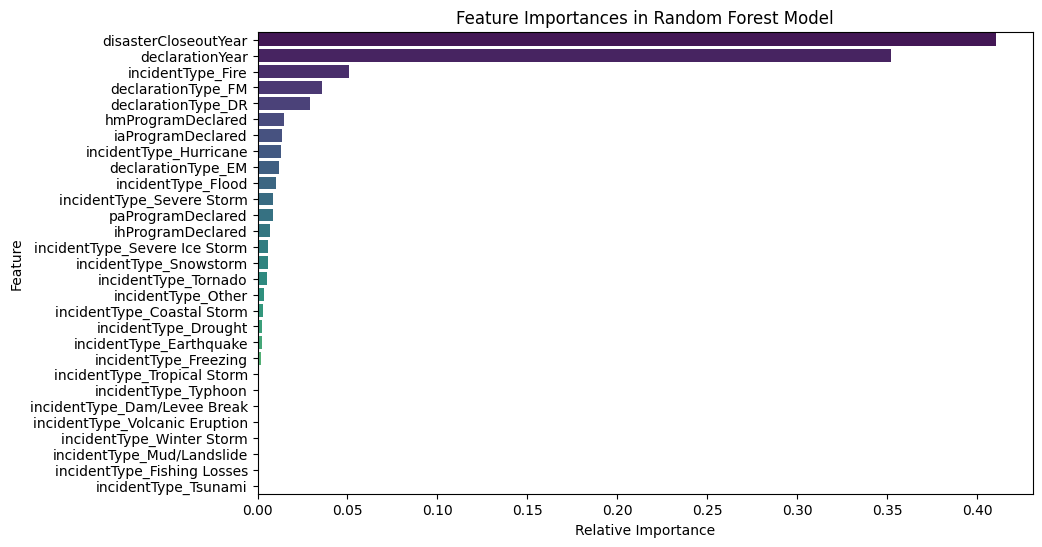

In [116]:
!pip install graphviz
from sklearn.tree import export_graphviz
import graphviz

chosen_tree = clf.estimators_[23]

dot_data = export_graphviz(chosen_tree, out_file=None,
                           feature_names=X.columns,
                           class_names=True,
                           filled=True, rounded=True,
                           special_characters=True)


# Draw graph
graph = graphviz.Source(dot_data, format="png")
graph

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.125015 to fit


'tree_high_res.png'

In [118]:
df_dummies_randomForest2=df_dummies_randomForest[['state','declarationYear','ihProgramDeclared', 'iaProgramDeclared', 'paProgramDeclared',
                                                 'hmProgramDeclared',  'declarationType_DR', 'declarationType_EM', 'declarationType_FM',
                                                 'incidentType_Coastal Storm', 'incidentType_Dam/Levee Break', 'incidentType_Drought',
                                                 'incidentType_Earthquake', 'incidentType_Fire', 'incidentType_Fishing Losses', 'incidentType_Flood',
                                                 'incidentType_Freezing', 'incidentType_Hurricane', 'incidentType_Mud/Landslide', 'incidentType_Other',
                                                 'incidentType_Severe Ice Storm', 'incidentType_Severe Storm', 'incidentType_Snowstorm',
                                                 'incidentType_Tornado', 'incidentType_Tropical Storm', 'incidentType_Tsunami', 'incidentType_Typhoon',
                                                 'incidentType_Volcanic Eruption', 'incidentType_Winter Storm']]


In [119]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

# Separate features and target variable
X = df_dummies_randomForest2.drop('state', axis=1)
y = df_dummies_randomForest2['state']

# Split the Data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Train the Model
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train)

# Validate the Model
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

# Feature Importance
feature_importances = pd.DataFrame(clf.feature_importances_, index=X_train.columns, columns=['importance']).sort_values('importance', ascending=False)
print(feature_importances)


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



              precision    recall  f1-score   support

          AK       0.98      0.37      0.54       143
          AL       0.26      0.12      0.16       534
          AR       0.34      0.29      0.31       601
          AS       0.81      0.50      0.62        26
          AZ       0.15      0.03      0.05       133
          CA       0.50      0.42      0.46       759
          CO       0.45      0.34      0.39       404
          CT       0.83      0.07      0.13        72
          DC       0.00      0.00      0.00         9
          DE       0.00      0.00      0.00        23
          FL       0.60      0.33      0.43      1206
          FM       0.67      0.44      0.53         9
          GA       0.30      0.58      0.39       995
          GU       0.00      0.00      0.00         8
          HI       1.00      0.19      0.32        42
          IA       0.26      0.34      0.29       738
          ID       1.00      0.10      0.18       188
          IL       0.47    

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



In [120]:
df_dummies_randomForest3=df_dummies_randomForest[['state','ihProgramDeclared', 'iaProgramDeclared', 'paProgramDeclared',
                                                 'hmProgramDeclared',  'declarationType_DR', 'declarationType_EM', 'declarationType_FM',
                                                 'incidentType_Coastal Storm', 'incidentType_Dam/Levee Break', 'incidentType_Drought',
                                                 'incidentType_Earthquake', 'incidentType_Fire', 'incidentType_Fishing Losses', 'incidentType_Flood',
                                                 'incidentType_Freezing', 'incidentType_Hurricane', 'incidentType_Mud/Landslide', 'incidentType_Other',
                                                 'incidentType_Severe Ice Storm', 'incidentType_Severe Storm', 'incidentType_Snowstorm',
                                                 'incidentType_Tornado', 'incidentType_Tropical Storm', 'incidentType_Tsunami', 'incidentType_Typhoon',
                                                 'incidentType_Volcanic Eruption', 'incidentType_Winter Storm']]


In [121]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

# Separate features and target variable
X = df_dummies_randomForest3.drop('state', axis=1)
y = df_dummies_randomForest3['state']

# Split the Data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Train the Model
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train)

# Validate the Model
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

# Feature Importance
feature_importances = pd.DataFrame(clf.feature_importances_, index=X_train.columns, columns=['importance']).sort_values('importance', ascending=False)
print(feature_importances)


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



              precision    recall  f1-score   support

          AK       0.38      0.34      0.36       143
          AL       0.25      0.00      0.00       534
          AR       0.18      0.02      0.04       601
          AS       0.25      0.04      0.07        26
          AZ       0.00      0.00      0.00       133
          CA       0.44      0.17      0.25       759
          CO       0.85      0.04      0.08       404
          CT       1.00      0.03      0.05        72
          DC       0.00      0.00      0.00         9
          DE       0.00      0.00      0.00        23
          FL       0.35      0.10      0.16      1206
          FM       0.00      0.00      0.00         9
          GA       0.12      0.07      0.09       995
          GU       0.33      0.12      0.18         8
          HI       0.50      0.07      0.12        42
          IA       0.09      0.19      0.12       738
          ID       0.00      0.00      0.00       188
          IL       0.45    

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



## Other Data Reviewed but Not Yet Used
(aka the TBD graveyard)

In [ ]:

top=5000
skip=0
baseUrl = 'https://www.fema.gov/api/open/v1/DeclarationDenials?'
res = requests.get(baseUrl+'$count=true&$top=1')
response = res.json()
recCount = response['metadata']['count']
loopNum = math.ceil(recCount / top)

print("START " + str(datetime.now()) + ", " + str(recCount) + " records, " + str(top) + " returned per call, " + str(loopNum) + " iterations needed.")

df_denied = pd.DataFrame.from_dict(response['DeclarationDenials'])[0:0]
i = 0
while (i < loopNum):
  print(baseUrl + "$skip=" + str(skip) + "&$top=" + str(top))
  webUrl = requests.get(baseUrl + "$skip=" + str(skip) + "&$top=" + str(top)).json()
  df_denied=pd.concat([df_denied,pd.DataFrame.from_dict(webUrl['DeclarationDenials'])])
  i+=1
  skip = i * top
  print("Iteration " + str(i) + " done")

print("END " + str(datetime.now()) + ", " + str(len(df_denied)) + " records in file")

START 2023-12-04 19:03:35.955395, 303 records, 5000 returned per call, 1 iterations needed.
https://www.fema.gov/api/open/v1/DeclarationDenials?$skip=0&$top=5000
Iteration 1 done
END 2023-12-04 19:03:36.116514, 303 records in file


In [ ]:
top=5000
skip=0
baseUrl = 'https://www.fema.gov/api/open/v1/MissionAssignments?'
res = requests.get(baseUrl+'$count=true&$top=1')
response = res.json()
recCount = response['metadata']['count']
loopNum = math.ceil(recCount / top)

print("START " + str(datetime.now()) + ", " + str(recCount) + " records, " + str(top) + " returned per call, " + str(loopNum) + " iterations needed.")

df_mission = pd.DataFrame.from_dict(response['MissionAssignments'])[0:0]
i = 0
while (i < loopNum):
  print(baseUrl + "$skip=" + str(skip) + "&$top=" + str(top))
  webUrl = requests.get(baseUrl + "$skip=" + str(skip) + "&$top=" + str(top)).json()
  df_mission=pd.concat([df_mission,pd.DataFrame.from_dict(webUrl['MissionAssignments'])])
  i+=1
  skip = i * top
  print("Iteration " + str(i) + " done")

print("END " + str(datetime.now()) + ", " + str(len(df_mission)) + " records in file")

START 2023-12-04 19:09:19.497153, 28184 records, 5000 returned per call, 6 iterations needed.
https://www.fema.gov/api/open/v1/MissionAssignments?$skip=0&$top=5000
Iteration 1 done
https://www.fema.gov/api/open/v1/MissionAssignments?$skip=5000&$top=5000
Iteration 2 done
https://www.fema.gov/api/open/v1/MissionAssignments?$skip=10000&$top=5000
Iteration 3 done
https://www.fema.gov/api/open/v1/MissionAssignments?$skip=15000&$top=5000
Iteration 4 done
https://www.fema.gov/api/open/v1/MissionAssignments?$skip=20000&$top=5000
Iteration 5 done
https://www.fema.gov/api/open/v1/MissionAssignments?$skip=25000&$top=5000
Iteration 6 done
END 2023-12-04 19:09:31.989286, 28184 records in file


In [ ]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import gzip
import io

# URL containing the .csv.gz files
url = 'https://www.ncei.noaa.gov/pub/data/swdi/stormevents/csvfiles/'

# Send a GET request to the URL
response = requests.get(url)
soup = BeautifulSoup(response.text, 'html.parser')

# Find all .csv.gz links
links = [a['href'] for a in soup.find_all('a') if ((a['href'].endswith('.csv.gz'))&(a['href'].startswith('StormEvents_details')))]

# Initialize an empty DataFrame to hold all data
all_data = pd.DataFrame()

# Loop through each link, download, unzip, and read the data
for link in links:
    # Download the file content
    file_url = url + link
    file_response = requests.get(file_url)

    # Unzip the file content
    with gzip.open(io.BytesIO(file_response.content), 'rt') as file:
        # Read the unzipped content into a DataFrame
        df = pd.read_csv(file,low_memory=False,converters={'STATE_FIPS': str,'CZ_FIPS': str})

        # Append to the main DataFrame
        all_data = pd.concat([all_data, df], ignore_index=True)

# all_data now contains all the data from the .csv.gz files


In [ ]:
all_data

BEGIN_YEARMONTH  BEGIN_DAY  BEGIN_TIME  END_YEARMONTH  END_DAY  \
0                 195004         28        1445         195004       28   
1                 195004         29        1530         195004       29   
2                 195007          5        1800         195007        5   
3                 195007          5        1830         195007        5   
4                 195007         24        1440         195007       24   
...                  ...        ...         ...            ...      ...   
1857531           202308          1           0         202308       31   
1857532           202308          8        1355         202308        8   
1857533           202308         25        2155         202308       25   
1857534           202308         25        2200         202308       25   
1857535           202308         25        2140         202308       25   

         END_TIME  EPISODE_ID  EVENT_ID         STATE STATE_FIPS  ...  \
0            1445         NaN  10096222      OKLAHOMA         40  ...   
1            1530         NaN  10120412         TEXAS         48  ...   
2            1800         NaN  10104927  PENNSYLVANIA         42  ...   
3            1830         NaN  10104928  PENNSYLVANIA         42  ...   
4            1440         NaN  10104929  PENNSYLVANIA         42  ...   
...           ...         ...       ...           ...        ...  ...   
1857531      2359    185278.0   1135907     WISCONSIN         55  ...   
1857532      1355    184461.0   1129174       WYOMING         56  ...   
1857533      2155    183053.0   1119593      NEBRASKA         31  ...   
1857534      2200    183053.0   1119594      NEBRASKA         31  ...   
1857535      2155    183053.0   1119597      NEBRASKA         31  ...   

         END_RANGE END_AZIMUTH END_LOCATION BEGIN_LAT BEGIN_LON END_LAT  \
0              0.0         NaN          NaN   35.1200  -99.2000   35.17   
1              0.0         NaN          NaN   31.9000  -98.6000   31.73   
2              0.0         NaN          NaN   40.5800  -75.7000   40.65   
3              0.0         NaN          NaN   40.6000  -76.7500     NaN   
4              0.0         NaN          NaN   41.6300  -79.6800     NaN   
...            ...         ...          ...       ...       ...     ...   
1857531        NaN         NaN          NaN       NaN       NaN     NaN   
1857532        2.0           S         ACME   44.8900 -106.9700   44.89   
1857533        2.0           N      CHESTER   40.0500  -97.6200   40.05   
1857534        4.0         SSE      DESHLER   40.0900  -97.6900   40.09   
1857535        0.0           N       GILEAD   40.0089  -97.4969   40.15   

        END_LON                                  EPISODE_NARRATIVE  \
0        -99.20                                                NaN   
1        -98.60                                                NaN   
2        -75.47                                                NaN   
3           NaN                                                NaN   
4           NaN                                                NaN   
...         ...                                                ...   
1857531     NaN  Abnormally dry to moderate drought conditions ...   
1857532 -106.97  An isolated thunderstorm produced quarter size...   
1857533  -97.62  Scattered instances of strong to marginally se...   
1857534  -97.69  Scattered instances of strong to marginally se...   
1857535  -97.41  Scattered instances of strong to marginally se...   

                                           EVENT_NARRATIVE DATA_SOURCE  
0                                                      NaN         PUB  
1                                                      NaN         PUB  
2                                                      NaN         PUB  
3                                                      NaN         PUB  
4                                                      NaN         PUB  
...                                                

In [140]:
"""for x in all_data:
  print(all_data[x].value_counts())
  print("")"""
#commented out to save space.

'for x in all_data:\n  print(all_data[x].value_counts())\n  print("")'

In [ ]:
all_data['DAMAGE_CROPS'] = all_data['DAMAGE_CROPS'].astype(str)
analyze_report = sv.analyze(all_data, pairwise_analysis="on")
analyze_report.show_html('Storm_Data EDA.html', open_browser=True)
analyze_report.show_notebook(w=None,
                h=None,
                scale=0.8,
                layout='vertical',
                filepath=None)

In [ ]:
all_data['fipsStateCode'] = all_data['STATE_FIPS'].apply(lambda num: str(num).zfill(2))
all_data['fipsCountyCode'] = all_data['CZ_FIPS'].apply(lambda num: str(num).zfill(3))
all_data['fips'] = all_data['fipsStateCode'] + all_data['fipsCountyCode']
all_data.groupby(['EVENT_TYPE']).count().reset_index()

EVENT_TYPE  BEGIN_YEARMONTH  BEGIN_DAY  BEGIN_TIME  \
0   Astronomical Low Tide              664        664         664   
1               Avalanche              795        795         795   
2                Blizzard            15965      15965       15965   
3           Coastal Flood             3811       3811        3811   
4         Cold/Wind Chill            16191      16191       16191   
..                    ...              ...        ...         ...   
65       Volcanic Ashfall               76         76          76   
66             Waterspout             5829       5829        5829   
67               Wildfire             8552       8552        8552   
68           Winter Storm            84819      84819       84819   
69         Winter Weather            74663      74663       74663   

    END_YEARMONTH  END_DAY  END_TIME  EPISODE_ID  EVENT_ID  STATE  ...  \
0             664      664       664         664       664    664  ...   
1             795      795       795         795       795    795  ...   
2           15965    15965     15965       15965     15965  15965  ...   
3            3811     3811      3811        3811      3811   3811  ...   
4           16191    16191     16191       16191     16191  16191  ...   
..            ...      ...       ...         ...       ...    ...  ...   
65             76       76        76          76        76     76  ...   
66           5829     5829      5829        5829      5829   5828  ...   
67           8552     8552      8552        8552      8552   8552  ...   
68          84819    84819     84819       84819     84819  84819  ...   
69          74663    74663     74663       74663     74663  74663  ...   

    BEGIN_LAT  BEGIN_LON  END_LAT  END_LON  EPISODE_NARRATIVE  \
0           0          0        0        0                664   
1           0          0        0        0                703   
2           0          0        0        0              15548   
3           0          0        0        0               3781   
4           0          0        0        0              15949   
..        ...        ...      ...      ...                ...   
65          0          0        0        0                 76   
66       3911       3911     3911     3911               4073   
67          0          0        0        0               7806   
68          0          0        0        0              82643   
69          0          0        0        0              74235   

    EVENT_NARRATIVE  DATA_SOURCE  fipsStateCode  fipsCountyCode   fips  
0               317          664            664             664    664  
1               541          795            795             795    795  
2              6540        15965          15965           15965  15965  
3              2684         3811           3811            3811   3811  
4              4348        16191          16191           16191  16191  
..              ...          ...            ...             ...    ...  
65               11           76             76              76     76  
66             4951         5829           5829            5829   5829  
67             4901         8552           8552            8552   8552  
68            38598        84819          84819           84819  84819  
69            42704        74663          74663           74663  74663  

[70 rows x 54 columns]

In [ ]:
crosswalk_dict = {
    'Winter Weather': 'Winter Storm',
    'Winter Storm': 'Winter Storm',
    'Wildfire': 'Fire',
    'Waterspout': 'Severe Storm',
    'Volcanic Ashfall': 'Volcanic Eruption',
    'Volcanic Ash': 'Volcanic Eruption',
    'Tsunami': 'Tsunami',
    'Tropical Storm': 'Tropical Storm',
    'Tropical Depression': 'Tropical Storm',
    'Tornado': 'Tornado',
    'Thunderstorm Wind': 'Severe Storm',
    'TORNADOES, TSTM WIND, HAIL': 'Severe Storm',
    'TORNADO/WATERSPOUT': 'Tornado',
    'THUNDERSTORM WINDS/HEAVY RAIN': 'Severe Storm',
    'THUNDERSTORM WINDS/FLOODING': 'Flood',
    'THUNDERSTORM WINDS/FLASH FLOOD': 'Flood',
    'THUNDERSTORM WINDS/ FLOOD': 'Flood',
    'THUNDERSTORM WINDS LIGHTNING': 'Severe Storm',
    'THUNDERSTORM WINDS HEAVY RAIN': 'Severe Storm',
    'THUNDERSTORM WINDS FUNNEL CLOUD': 'Severe Storm',
    'THUNDERSTORM WIND/ TREES': 'Severe Storm',
    'THUNDERSTORM WIND/ TREE': 'Severe Storm',
    'Strong Wind': 'Severe Storm',
    'Storm Surge/Tide': 'Coastal Storm',
    'Sneakerwave': 'Other',
    'Sleet': 'Winter Storm',
    'Seiche': 'Other',
    'Rip Current': 'Other',
    'Northern Lights': 'Other',
    'Marine Tropical Storm': 'Tropical Storm',
    'Marine Tropical Depression': 'Tropical Storm',
    'Marine Thunderstorm Wind': 'Severe Storm',
    'Marine Strong Wind': 'Severe Storm',
    'Marine Lightning': 'Severe Storm',
    'Marine Hurricane/Typhoon': 'Hurricane',
    'Marine High Wind': 'Severe Storm',
    'Marine Hail': 'Severe Storm',
    'Marine Dense Fog': 'Other',
    'Lightning': 'Severe Storm',
    'Lakeshore Flood': 'Coastal Storm',
    'Lake-Effect Snow': 'Snowstorm',
    'Ice Storm': 'Severe Ice Storm',
    'Hurricane (Typhoon)': 'Hurricane',
    'Hurricane': 'Hurricane',
    'High Wind': 'Severe Storm',
    'High Surf': 'Coastal Storm',
    'Heavy Snow': 'Snowstorm',
    'Heavy Rain': 'Severe Storm',
    'Heat': 'Other',
    'Hail': 'Severe Storm',
    'HAIL/ICY ROADS': 'Winter Storm',
    'HAIL FLOODING': 'Flood',
    'Funnel Cloud': 'Severe Storm',
    'Frost/Freeze': 'Freezing',
    'Freezing Fog': 'Winter Storm',
    'Flood': 'Flood',
    'Flash Flood': 'Flood',
    'Extreme Cold/Wind Chill': 'Winter Storm',
    'Excessive Heat': 'Other',
    'Dust Storm': 'Other',
    'Dust Devil': 'Other',
    'Drought': 'Drought',
    'Dense Smoke': 'Fire',
    'Dense Fog': 'Other',
    'Debris Flow': 'Mud/Landslide',
    'Cold/Wind Chill': 'Winter Storm',
    'Coastal Flood': 'Coastal Storm',
    'Blizzard': 'Winter Storm',
    'Avalanche': 'Other',
    'Astronomical Low Tide': 'Other'
}
all_data['incidentType'] = all_data['EVENT_TYPE'].apply(lambda x: crosswalk_dict.get(x, 'Unknown'))
all_data['incidentType'].value_counts()

Severe Storm         1134474
Winter Storm          208598
Flood                 164154
Tornado                76403
Snowstorm              73278
Drought                71728
Other                  65535
Coastal Storm          16151
Freezing               14268
Severe Ice Storm       12166
Fire                    8698
Tropical Storm          7576
Hurricane               2169
Mud/Landslide           2148
Volcanic Eruption        146
Tsunami                   42
Unknown                    2
Name: incidentType, dtype: int64